#DD2424 Deep Learning, KTH

##Assignment 2

Author: Prashant Yadava (yadava@kth.se)

The assignment involves training a two-layer (input-hidden and hidden-output) neural network to classify images from the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. The task is structured around using mini-batch gradient descent combined with cyclical learning rates and regularization techniques to optimize the network's performance.

The network consists of two layers:
* an input layer with a ReLU activation function and
* an output layer that uses a softmax function for classification.

We need to implement both the forward pass and the backward pass (gradient computation).

In [9]:
import pickle
import numpy as np
import numpy.testing as npt

import matplotlib.pyplot as plt
import random
import os

from matplotlib.backends.backend_pdf import PdfPages

* Dataset: CIFAR-10
* Training Data: ```data_batch_1```
* Validation Data: ```data_batch_2```
* Test data: ```test_batch```



##Obtain the data

CIFAR-10: labeled subsets of 80 million tiny images datasets

The original data is available at
[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz)

Below we download and extract the data locally to a folder.

Modules used:
1. [urlretrieve](https://docs.python.org/3.0/library/urllib.request.html) : working with network objects
2. [tarfile](https://docs.python.org/2/library/tarfile.html) : handling tar files
3. [tqdm](https://pypi.python.org/pypi/tqdm) : progress monitor

In [10]:
cifar_10_url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
cifar_10_file = 'cifar-10-python.tar.gz'

from urllib.request import urlretrieve
from os.path import  isfile, isdir
from tqdm import tqdm #progress bar etc
import tarfile #ability to read and write tar files


cifar10_data_folder_path = 'cifar-10-batches-py'

class DownloadProgress(tqdm):
  last_block = 0

  def hook(self, block_num=1, block_size=1, total_size=None):
    if total_size is not None:
      self.total = total_size
      self.update(block_num * block_size - self.n)

  """
  check if the file is already existing, if not, download it from the source
  """

if not isfile(cifar_10_file):
  with DownloadProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
    #retrieve a url into a temporary location on the disk
    urlretrieve(
        cifar_10_url,
        cifar_10_file,
        pbar.hook
    )

if not isdir(cifar10_data_folder_path):
  with tarfile.open(cifar_10_file) as tar:
    tar.extractall()
    tar.close()



Labels:
The labels listed in the correct order as per the CIFAR datasets

In [11]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

#Read in the data
### Function to load a data batch (used only for insights)
Next we create a function which loads a batch based on a requested batch index. The function returns the features (the RGB values for each of the 32x32 pixel) for each image, as well as the image label.

In [12]:
def load_batch(cifar10_data_folder_path, batch_id):
  with open(cifar10_data_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
    batch = pickle.load(file, encoding='latin1')

  features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0,2,3,1)
  labels = batch['labels']

  return features, labels

#Insights into data

In [13]:
def display_stats(cifar10_data_folder_path, batch_id, sample_id):
  features, labels = load_batch(cifar10_data_folder_path, batch_id)

  if not (0 <= sample_id < len(features)):
    print ('{} samples in batch {}. {} is out of range.'.format(len(features), batch_id, sample_id))
    return None

  print('\nStats of batch #{}:'.format(batch_id))
  print('# of Samples: {}\n'.format(len(features)))

  label_names = load_label_names()
  label_counts = dict(zip(*np.unique(labels, return_counts=True)))

  for key, value in label_counts.items():
    print('Label Counts of [{}]({}) : {}'.format(key, label_names[key].upper(), value))

  sample_image = features[sample_id]
  sample_label = labels[sample_id]

  print('\n Example of Image {}'.format(sample_id))
  print('Image - Min Value : {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
  print('Image - Shape: {}'.format(sample_image.shape))
  print('Label - Lable Id: {} Name: {}'.format(sample_label, label_names[sample_label]))

  plt.figure(figsize=(2, 2))  # figsize=(width, height) in inches
  plt.imshow(sample_image)
  plt.show()

# Checking out some random images in the datasets


Stats of batch #2:
# of Samples: 10000

Label Counts of [0](AIRPLANE) : 984
Label Counts of [1](AUTOMOBILE) : 1007
Label Counts of [2](BIRD) : 1010
Label Counts of [3](CAT) : 995
Label Counts of [4](DEER) : 1010
Label Counts of [5](DOG) : 988
Label Counts of [6](FROG) : 1008
Label Counts of [7](HORSE) : 1026
Label Counts of [8](SHIP) : 987
Label Counts of [9](TRUCK) : 985

 Example of Image 6272
Image - Min Value : 45 Max Value: 255
Image - Shape: (32, 32, 3)
Label - Lable Id: 1 Name: automobile


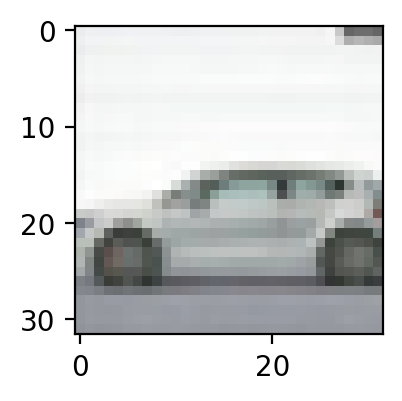


Stats of batch #2:
# of Samples: 10000

Label Counts of [0](AIRPLANE) : 984
Label Counts of [1](AUTOMOBILE) : 1007
Label Counts of [2](BIRD) : 1010
Label Counts of [3](CAT) : 995
Label Counts of [4](DEER) : 1010
Label Counts of [5](DOG) : 988
Label Counts of [6](FROG) : 1008
Label Counts of [7](HORSE) : 1026
Label Counts of [8](SHIP) : 987
Label Counts of [9](TRUCK) : 985

 Example of Image 9548
Image - Min Value : 68 Max Value: 255
Image - Shape: (32, 32, 3)
Label - Lable Id: 4 Name: deer


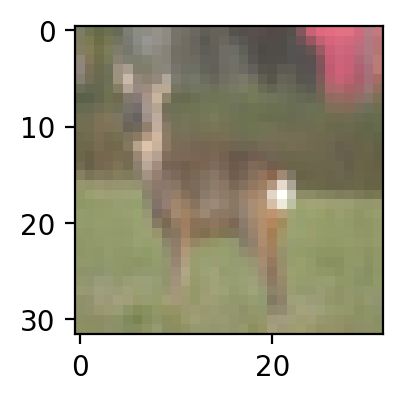


Stats of batch #2:
# of Samples: 10000

Label Counts of [0](AIRPLANE) : 984
Label Counts of [1](AUTOMOBILE) : 1007
Label Counts of [2](BIRD) : 1010
Label Counts of [3](CAT) : 995
Label Counts of [4](DEER) : 1010
Label Counts of [5](DOG) : 988
Label Counts of [6](FROG) : 1008
Label Counts of [7](HORSE) : 1026
Label Counts of [8](SHIP) : 987
Label Counts of [9](TRUCK) : 985

 Example of Image 2991
Image - Min Value : 1 Max Value: 255
Image - Shape: (32, 32, 3)
Label - Lable Id: 0 Name: airplane


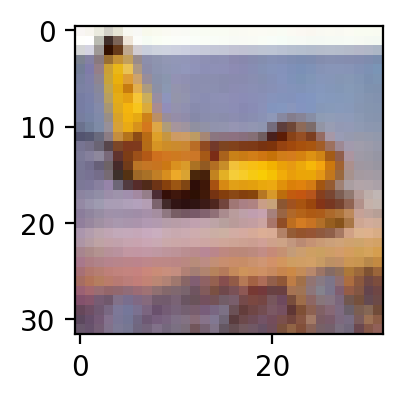


Stats of batch #2:
# of Samples: 10000

Label Counts of [0](AIRPLANE) : 984
Label Counts of [1](AUTOMOBILE) : 1007
Label Counts of [2](BIRD) : 1010
Label Counts of [3](CAT) : 995
Label Counts of [4](DEER) : 1010
Label Counts of [5](DOG) : 988
Label Counts of [6](FROG) : 1008
Label Counts of [7](HORSE) : 1026
Label Counts of [8](SHIP) : 987
Label Counts of [9](TRUCK) : 985

 Example of Image 3576
Image - Min Value : 17 Max Value: 239
Image - Shape: (32, 32, 3)
Label - Lable Id: 8 Name: ship


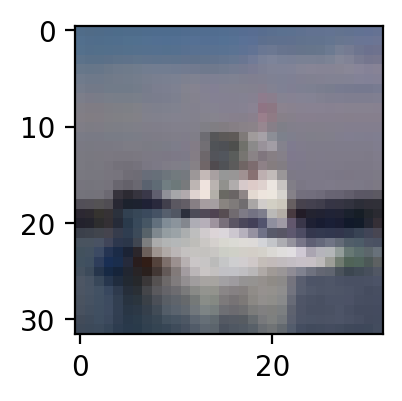


Stats of batch #2:
# of Samples: 10000

Label Counts of [0](AIRPLANE) : 984
Label Counts of [1](AUTOMOBILE) : 1007
Label Counts of [2](BIRD) : 1010
Label Counts of [3](CAT) : 995
Label Counts of [4](DEER) : 1010
Label Counts of [5](DOG) : 988
Label Counts of [6](FROG) : 1008
Label Counts of [7](HORSE) : 1026
Label Counts of [8](SHIP) : 987
Label Counts of [9](TRUCK) : 985

 Example of Image 2741
Image - Min Value : 1 Max Value: 255
Image - Shape: (32, 32, 3)
Label - Lable Id: 1 Name: automobile


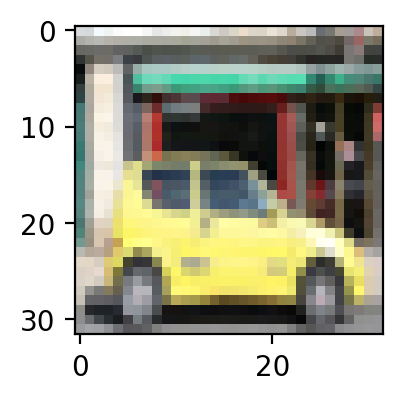

In [14]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
#explore the validation dataset
batch_id = 2
#sample_id = random.randint(0,10000) #some random image
sample_ids = random.sample(range(10001), 5)
for sid in sample_ids:
  display_stats(cifar10_data_folder_path, batch_id, sid)
  #plt.imshow(simg)

#1. Load Batch
This function loads the given batch files and returns X, Y, y according to the properties given below.

For classification tasks, especially in neural networks, it's common to represent the target classes in a one-hot encoded format. This format converts categorical class labels into a binary matrix representation.

* ```X``` contains the image pixel data, has size ```d×n```, is of type double or single and has entries between 0 and 1. n is the number of images (10000) and d the dimensionality of each image (3072=32×32×3).
* ```Y``` is ```K×n``` (```K```= # of labels = 10) and contains the one-hot representation of the label for each image.
* ```y``` is a vector of length n containing the label for each image.

In [15]:
def loadBatch(batchfile_name):

  with open(batchfile_name, mode='rb') as file:
    batch = pickle.load(file, encoding='latin1')
  X = (batch['data']/255).T # Transpose to shape (3072, 10000)
  y = batch['labels']
  Y = (np.eye(10)[y]).T # Shape (10, 10000)

  return X, Y, y

#Exercise 1: Read in the data & initialize the parameters of the network



# 1. Read the data batches

In [16]:
#numpy Array, List
print("train data:")
batch_id = 1
train_X, train_Y, train_y = loadBatch(cifar10_data_folder_path + '/data_batch_' + str(batch_id))
print("====================")
batch_id = 2
print("validation data:")
val_X, val_Y, val_y = loadBatch(cifar10_data_folder_path + '/data_batch_' + str(batch_id))
print("====================")
print("test data:")
test_X, test_Y, test_y = loadBatch(cifar10_data_folder_path + '/test_batch')

print('Shape of train_X: ', train_X.shape)
print(type(train_X))
print(train_X.dtype)


train data:
validation data:
test data:
Shape of train_X:  (3072, 10000)
<class 'numpy.ndarray'>
float64


#2. Pre-process the raw input data

Pre-processing the raw input data makes it more suitable for the training of a machine learning model.

Normalize the datasets:
The training, validation, and test data are all normalized using the mean and standard deviation values computed from the training data. This ensures consistency in pre-processing across different sets of data.

It consists of:
* Subtracting the mean from each column (image) and then
* dividing by the standard deviation of the corresponding feature.

In [17]:
#print(type(train_X))
#print(train_X.shape)

#Compute the mean of each channel

mean_X = np.mean(train_X, axis=1, keepdims=True)
train_X_zero_mean = train_X - mean_X

mean_channel_after = np.mean(train_X_zero_mean, axis=1, keepdims=True)

print("Mean of each channel before zero-mean operation:")
print("Red:   ", mean_X[0])
print("Green: ", mean_X[1])
print("Blue:  ", mean_X[2])
print("\nMean of each channel after zero-mean operation:")
print("(values are close to 0)")
print("Red:   ", mean_channel_after[0])
print("Green: ", mean_channel_after[1])
print("Blue:  ", mean_channel_after[2])

#Compute the standard deviation vector along the columns
std_X = np.std(train_X_zero_mean, axis=1, keepdims=True)

#Divide each pixel value by its corresponding standard deviation
train_X_norm = train_X_zero_mean / std_X


Mean of each channel before zero-mean operation:
Red:    [0.51767961]
Green:  [0.51502588]
Blue:   [0.51840471]

Mean of each channel after zero-mean operation:
(values are close to 0)
Red:    [3.27909921e-16]
Green:  [-1.91170413e-15]
Blue:   [-9.40053591e-16]


Now the **```train_X_norm```** contains pre-processed training data with zero mean and unit variance. We repeat the same pre-processing to the validation (**```val_X```**) and test data (**```test_X```**) as well to ensure consistency.


In [18]:
#Zero mean
val_X_zero_mean = val_X - mean_X
test_X_zero_mean = test_X - mean_X

#unit variance
val_X_norm = val_X_zero_mean / std_X
test_X_norm = test_X_zero_mean / std_X

Before we proceed, lets verify the pre-processing results

In [19]:
#Verify
#Train data
mean_X_train = np.mean(train_X_norm, axis=1)
std_X_train = np.std(train_X_norm, axis=1)

#Validation data
mean_X_val = np.mean(val_X_norm, axis=1)
std_X_val = np.std(val_X_norm, axis=1)

#Test data
mean_X_test = np.mean(test_X_norm, axis=1)
std_X_test = np.std(test_X_norm, axis=1)

# Print the mean and standard deviation for training data
print("Mean and Standard Deviation for Training Data:")
print("Mean: ", mean_X_train)
print("Standard Deviation: ", std_X_train)

# Print the mean and standard deviation for validation data
print("\nMean and Standard Deviation for Validation Data:")
print("Mean: ", mean_X_val)
print("Standard Deviation: ", std_X_val)

# Print the mean and standard deviation for test data
print("\nMean and Standard Deviation for Test Data:")
print("Mean: ", mean_X_test)
print("Standard Deviation: ", std_X_test)

Mean and Standard Deviation for Training Data:
Mean:  [ 1.14762644e-15 -6.72704115e-15 -3.30626637e-15 ...  1.98317307e-14
  1.67195313e-14  1.97693556e-14]
Standard Deviation:  [1. 1. 1. ... 1. 1. 1.]

Mean and Standard Deviation for Validation Data:
Mean:  [-0.02151247 -0.02224322 -0.02073346 ...  0.00306148  0.00081912
 -0.00583879]
Standard Deviation:  [0.9972366  0.99612618 0.99514764 ... 0.9918761  0.99197641 0.99003225]

Mean and Standard Deviation for Test Data:
Mean:  [-0.01997713 -0.01837621 -0.01445866 ...  0.01112209  0.00688517
  0.00331293]
Standard Deviation:  [0.99457784 0.99448534 0.99708297 ... 0.98394642 0.98458229 0.98249776]


Alright, so we indeed have 0 mean (or close to it, given the precision issues when performing floating-point arithmetic operations in computers). The standard deviation is also acceptably close to 1.

For simplicity in referring to the data batches, we rename the datasets.

In [20]:
train_X = train_X_norm
test_X = test_X_norm
val_X = val_X_norm

#3. Initialize the parameters of the model for learning phase

We have the following 4 parameters for the network which we have to learn from the labelled training data:
* W1
* b1
* W2
* b2

The bias vectors can be set to 0, while the weight matrices can be set to random draws from a Gaussian distribution with 0 mean and standard deviation 1/sqrt(d) for layer 1 and 1/sqrt(m) for layer 2,

where d: input layer

m: hidden layer (m=50 in our case)

We are following 'He Normal Initialization' method.

In [21]:
#d: 3072 (=32x32x3), K: 10
def initialize_parameters(input_dim, hidden_dim, output_dim, rseed=42):
  """
  Initialize the weights and biases for a two-layer network.

  Note: The scaling facotr such as np.sqrt(1./d) helps in controlling
        the variance of activations and gradients through the network, promoting a stable learning process
  Parameters:
  - input_dim: The number of input features
  - hidden_dim: The number of neurons in the hidden layer.
  - output_dim: The number of output classes.

  Returns:
  - params: A dictionary containing the parameters "W1", "b1", "W2", "b2".
  """

  np.random.seed(rseed)  # Seed for reproducibility
  W1 = np.random.randn(hidden_dim, input_dim) * np.sqrt(1.0/input_dim) #0.01
  b1 = np.zeros((hidden_dim, 1))
  W2 = np.random.randn(output_dim, hidden_dim) * np.sqrt(1.0/hidden_dim) #0.01
  b2 = np.zeros((output_dim, 1))
  return {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

#Exercise 2: Compute the gradients for the network parameters

# 4. Gradient Computation

##Forward Pass

the forward pass involves calculating the outputs of the neural network given the current parameters (weights and biases) and the input data. This step is crucial for both evaluating the performance of the network during training and for backpropagation where the gradients are computed.

Componens of the forward pass:
1.   ***First layer (Input to Hidden layer)***
* Compute the affine transformations, $s_1 = W_1x + b $
* Apply the ReLU activation function to introduce non-linearity, defined as $h = ReLU(s_1)$, where ReLU is max(0, s_1)
2.   ***Second layer (Hidden to Output layer)***
* Compute the second affine transformation, $s_2 = W_2h + b_2$
* $p = Softmax(s_2)$

Apply the softmax function to get the probabilities of each class. The softmax function converts the logits $s$ into probabilities by comparing the exponentials of each output relative to the sum of exponentials of all outputs.


The ReLU and softmax functions are the activation functions.
ReLU introduces non-linearity to help the network learn complex patterns.
Softmax turns logits into probabilities that sum to 1.



The cost function for the 2-layer neural network using cross-entropy loss and L2 regularization is given as follows:

$$J(D, \lambda, \Theta) = \frac{1}{|D|} \sum_{(x,y) \in D} l_{\text{cross}}(x, y, \Theta) + \frac{\lambda}{2} \sum_{l=1}^{2} \sum_{i,j} W_{l,ij}^2$$


In [22]:
def forward_pass(X, params):
    W1, b1, W2, b2 = params['W1'], params['b1'], params['W2'], params['b2']
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    Z2 = np.dot(W2, A1) + b2
    P = softmax(Z2) #we are taking care of numerical stability in softmax() function
    cache = (Z1, A1, Z2, P, X)
    return P, cache


## Backward Pass
Compute the gradients for the network parameters with respect to each paramter in the network (weights and biases).



1.   Gradient of Softmax with Cross-Entropy Loss:
2.   Gradients through the Layers:
  * **Second Layer (Output Layer)**:
  Calculate the gradient $ds$ as the difference between predictions p and true labels Y. Use this to compute gradients for  $W_2$ and  $b_2$ , including the regularization term.
  * **First Layer (Hidden Layer)**:
  Propagate the gradients back throuh the network by first calculating $dh$ as the product $W_{2}^{T}$ and $ds$. Then, apply the derivative of ReLU function to compute $ds1$. Finally, compute gradients for $W_1$ and $b_1$, including the regularization term.





In [23]:
def backward_pass(Y, cache, params):
    # Unpack cached values from the forward pass
    Z1, A1, Z2, P, X = cache
    W1, W2 = params['W1'], params['W2']
    m = Y.shape[1]  # Number of examples

    # Calculate gradients for the output layer
    # dZ2 is the "gradient of the loss" with-respect-to "the output" before softmax
    dZ2 = P - Y
    # dW2 is the gradient of the loss with respect to the weights of the second layer
    dW2 = np.dot(dZ2, A1.T) / m
    # db2 is the gradient of the loss with respect to the biases of the second layer
    db2 = np.sum(dZ2, axis=1, keepdims=True) / m

    # Include L2 regularization in the gradient of the weights
    dW2 += (lambda_ / m) * W2

    # Backpropagate through the hidden layer
    # dA1 is the gradient of the loss with respect to the activation (output) of the first layer
    dA1 = np.dot(W2.T, dZ2)
    # dZ1 is the gradient of the loss with respect to the input of the first layer's activation function
    # This uses the derivative of the ReLU function, which is 0 where Z1 <= 0 and 1 where Z1 > 0
    dZ1 = dA1 * (Z1 > 0)

    # Calculate gradients for the first layer
    # dW1 is the gradient of the loss with respect to the weights of the first layer
    dW1 = np.dot(dZ1, X.T) / m
    # db1 is the gradient of the loss with respect to the biases of the first layer
    db1 = np.sum(dZ1, axis=1, keepdims=True) / m

    # Include L2 regularization in the gradient of the weights
    dW1 += (lambda_ / m) * W1

    # Package gradients into a dictionary
    grads = {'W1': dW1, 'b1': db1, 'W2': dW2, 'b2': db2}
    return grads

## Cost Function
This function will be used during training to evaluate how well the model is performing and also used to peform backpropagation to update the weights.

Loss -> error in prediciton on a single training example.

Cost -> aggregate measure of loss across an entire dataset or over a batch of training examples.

Cost is often represented as the sum or average of the loss function.

###Accuracy

To compute accuracy, we'll compare the predicted class labels against the true labels.

In [24]:
def compute_accuracy(P, Y):
  predictions = np.argmax(P, axis=0)
  labels = np.argmax(Y, axis=0)
  accuracy = np.sum(predictions == labels) / Y.shape[1]  # Divide by the number of examples
  return accuracy

def compute_loss(Y, P):
    """
    Compute the cross-entropy loss.

    Parameters:
    - Y: True labels, one-hot encoded.
    - P: Predictions (probabilities) from the network.

    Returns:
    - loss: The computed cross-entropy loss.
    """
    m = Y.shape[1]  # Number of examples
    log_probs = -np.log(P[Y.astype(bool)] + 1e-8)  # Adding a small number for numerical stability
    loss = np.sum(log_probs) / m
    return loss


def compute_cost(Y, P, params, lambda_=0):
    """
    Compute the cost including cross-entropy loss and L2 regularization.

    Parameters:
    - Y: True labels, one-hot encoded.
    - P: Predictions (probabilities) from the network.
    - params: Dictionary containing the network parameters "W1", "b1", "W2", "b2".
    - lambda_: Regularization strength.

    Returns:
    - cost: The computed cost including loss and regularization.
    """
    m = Y.shape[1]  # Number of examples
    cross_entropy_loss = compute_loss(Y, P)

    # Compute L2 regularization term from weights
    L2_reg = sum(np.sum(np.square(params[key])) for key in params if key.startswith('W'))
    #L2_reg = sum([np.sum(np.square(params[key])) for key in params if 'W' in key])   #takes care of W1 and W2 both!
    L2_cost = (lambda_ / (2 * m)) * L2_reg

    # Combine loss and regularization to get the cost
    cost = cross_entropy_loss + L2_cost
    return cost


In [25]:
def compute_cost_without_regularization(Y, P):
    m = Y.shape[1]
    # Safe computation of log probabilities
    log_probs = -np.log(P + 1e-8)
    # Element-wise multiplication with the one-hot encoded labels and sum over classes for each example
    cross_entropy_loss = np.sum(log_probs * Y) / m
    return cross_entropy_loss

def compute_cost_orig(Y, P, lambda_=0):
    """
    Compute the cross-entropy loss possibly with regularization.

    Parameters:
    - Y: True labels, one-hot encoded.
    - P: Predictions from the network.
    - lambda_: Regularization strength.

    Returns:
    - cost: Computed cost including loss and regularization.
    """
    m = Y.shape[1]  # Number of examples
    # Compute cross-entropy loss
    log_probs = -np.log(P[Y.astype(bool)] + 1e-8)
    cross_entropy = np.sum(log_probs) / m

    # Add regularization if lambda_ > 0
    if lambda_ > 0:
        W1, W2 = params['W1'], params['W2']
        L2_reg = (lambda_ / (2 * m)) * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
        cost = cross_entropy + L2_reg
    else:
        cost = cross_entropy

    return cost


def relu(Z):
    return np.maximum(0, Z)

def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)

# 5. Verify correctness of gradient computation

Next, we test our backward pass implementation by comparing our computed gradients with numerical gradients.
This is crucial for ensuring your backpropagation is correct.

Numerical Gradient computation function (conversion of ComputeGrasNum.m to python code) below:


In [26]:
#This function J acts as a bridge between your compute_numerical_gradient function and the model's forward pass
#and cost computation. It should compute the total cost (including any regularization if used) using compute_cost
def J(X, Y, params, lambda_=0):
    """
    Compute the total cost for a given set of parameters, input data, and labels.

    Parameters:
    - X: Input data.
    - Y: True labels, one-hot encoded.
    - params: Current model parameters.
    - lambda_: Regularization strength (if applicable).

    Returns:
    - Total cost computed.
    """
    # Perform a forward pass to get predictions
    P, _ = forward_pass(X, params)  # Make sure this function returns predictions P

    # Compute the cost using your predefined compute_cost function
    cost = compute_cost_orig(Y, P)  # Assuming compute_cost does not handle lambda, add it if needed

    if lambda_ > 0:
        W1, W2 = params['W1'], params['W2']
        reg_term = lambda_ * (np.sum(W1**2) + np.sum(W2**2)) / (2 * X.shape[1])
        cost += reg_term

    return cost


def compute_numerical_gradient(J, params, h=1e-5):
    """
    Compute the numerical gradients of the cost function J using the central difference formula.

    Parameters:
    - J: Function to compute the cost.
    - params: Dictionary containing the network parameters "W1", "b1", "W2", "b2".
    - X: Input data.
    - Y: True labels, one-hot encoded.
    - lambda_: Regularization strength.
    - h: Small perturbation used to compute the central difference.

    Returns:
    - num_grads: Dictionary containing numerical gradients of each parameter.
    """
    num_grads = {}
    for key in params:
        # Initialize gradient array
        param_grad = np.zeros_like(params[key])
        it = np.nditer(params[key], flags=['multi_index'], op_flags=['readwrite'])
        while not it.finished:
            ix = it.multi_index
            # Save the original value
            original_value = params[key][ix]

            # Compute J(theta + h)
            params[key][ix] = original_value + h
            cost_plus_h = J(params)

            # Compute J(theta - h)
            params[key][ix] = original_value - h
            cost_minus_h = J(params)

            # Compute the gradient
            param_grad[ix] = (cost_plus_h - cost_minus_h) / (2 * h)

            # Restore the original value
            params[key][ix] = original_value
            it.iternext()
            #print(f"Processed {key}[{ix}]")  # Debugging output

        num_grads[key] = param_grad
        #print(f"Completed gradients for {key}")

    return num_grads


##Test and compare gradients

First we ensure our function is workign fine - we will take a small 'toy' dataset and have a quick check.

In [27]:
# Assuming forward_pass, compute_cost and other necessary functions are defined
# Setup your neural network context as previously defined
# Testing the setup
rseed = 34
lambda_ = 0.00

input_dim = 8
hidden_dim = 50
output_dim = 3

#Create a random dataset which is reasonably small
X = np.random.randn(input_dim, 5)  # 5 examples
Y = np.eye(output_dim)[np.random.choice(output_dim, 5)].T  # One-hot labels

# Now invoke the testing
params = initialize_parameters(input_dim, hidden_dim, output_dim, rseed=rseed)
P, cache = forward_pass(X, params)
grads = backward_pass(Y, cache, params) #Gradients computed analytically
#num_grads = compute_numerical_gradient(J, params, X, Y)
num_grads = compute_numerical_gradient(lambda params: J(X, Y, params, lambda_), params)


# Compare the gradients
for key in params:  # Using param keys because we adjusted backward_pass to match
    if key in num_grads:
        diff = np.linalg.norm(grads[key] - num_grads[key]) / (np.linalg.norm(grads[key]) + np.linalg.norm(num_grads[key]) + 1e-7)
        print(f'Relative difference for {key}: {diff}')
    else:
        print(f'Key {key} not found in numerical gradients.')


Relative difference for W1: 3.200979293072335e-08
Relative difference for b1: 3.2460632397600975e-08
Relative difference for W2: 3.588337504388624e-08
Relative difference for b2: 3.7434272742816366e-08


##Next we compare the gradient calculations on a slice of our real training dataset

In [28]:
rseed = 66
lambda_ = 0.0
input_dim = 20 #the number of input features
hidden_dim = 50 #the number of hidden layers
output_dim = 10 #the number of output classes
params = initialize_parameters(input_dim, hidden_dim, output_dim, rseed=rseed)


#Selection of a small subset of data and labels
num_features_select = 20
num_samples_to_select = 100 #Choose a small number for simplicity and speed
np.random.seed(66)
selected_indices = np.random.choice(input_dim, num_features_select, replace=False)

# Now use these indices to select features from your dataset
X_small = train_X[selected_indices, :num_samples_to_select]  # (20, num_samples_to_select)
Y_small = train_Y[:, :num_samples_to_select]  # (10, num_samples_to_select)

#Select the first 'num_samples_to_select' examples
#X_small = train_X[:, :num_samples_to_select] #(3072,10)
#Y_small = train_Y[:, :num_samples_to_select] #(10,10)

print(f"Shape: X_small: {X_small.shape}, Y_small: {Y_small.shape}")

#Initialize weight matrices
#(4 items) {
    #'W1': ndarray with shape (50, 3072),
    #'b1': ndarray with shape (50, 1),
    #'W2': ndarray with shape (10, 50),
    #'b2': ndarray with shape (10, 1)}



# Now invoke the testing
P, cache = forward_pass(X_small, params)
print(f"Shape: P: {P.shape}")
grads = backward_pass(Y_small, cache, params)
#num_grads = compute_numerical_gradient(J, params, X_small, Y_small)
num_grads = compute_numerical_gradient(lambda params: J(X_small, Y_small, params, lambda_), params)

# Compare the gradients
for key in params:  # Using param keys because we adjusted backward_pass to match
    if key in num_grads:
        diff = np.linalg.norm(grads[key] - num_grads[key]) / (np.linalg.norm(grads[key]) + np.linalg.norm(num_grads[key]) + 1e-7)
        print(f'Relative difference for {key}: {diff}')
    else:
        print(f'Key {key} not found in numerical gradients.')

Shape: X_small: (20, 100), Y_small: (10, 100)
Shape: P: (10, 100)
Relative difference for W1: 4.0415370017064554e-07
Relative difference for b1: 3.120560786931215e-07
Relative difference for W2: 3.7594296587128416e-07
Relative difference for b2: 2.331878651081477e-07


##Conclusion of comparision of numerical v/s analytical gradient computations

We have now established that the gradients calculated from the numerical and analytical methods are close. Hence, we can proceed with the rest of the assignment.

# Sanity check after ensuring gradient computation's correctness

Next, we try the check on a subset of our actual training dataset, as well as a subset of the Weights matrix.

We 'train' the model:
*   on a small amount of training data (100 samples),
*   regularization turned off (lambda = 0)
*   Train for 200 epochs
*   reasonable learning rate

Goal:
We will try to overfit on the training data and get very low loss after the 200 epochs.

If we can achive the said goal, we can be confident of our gradient computations and mini-batch gradient descent algorithms to be ok



## Sanity check on small dataset

In [29]:
num_samples_to_overfit = 100

input_dim = 3072 #the number of input features
hidden_dim = 50 #the number of hidden layers
output_dim = 10 #the number of output classes

#Step 1: Prepare a small dataset
X_small = train_X[:, :num_samples_to_overfit]
Y_small = train_Y[:, :num_samples_to_overfit]

#Step 2: Initialize Network Parameters
np.random.seed(42)
params = initialize_parameters(input_dim, hidden_dim, output_dim)

#Step 3: Define the training loop
def train_network(X, Y, params, epochs, learning_rate, lambda_=0):
    costs = []  # To store the cost at each epoch for monitoring

    for epoch in range(epochs):
        P, cache = forward_pass(X, params)
        cost = compute_cost(Y, P, params, lambda_)  # Make sure compute_cost can handle lambda
        costs.append(cost)

        grads = backward_pass(Y, cache, params)
        # Update parameters
        for key in params.keys():
            params[key] -= learning_rate * grads[key]

        if epoch % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Cost: {cost}")

    return params, costs

#Step 4: Train the network
epochs = 100
learning_rate = 0.01  # Adjust based on your network and how quickly it converges
trained_params, training_costs = train_network(X_small, Y_small, params, epochs, learning_rate, lambda_=0)



Epoch 1/100, Cost: 2.488568659440679
Epoch 11/100, Cost: 1.5812454732548218
Epoch 21/100, Cost: 1.1841941608835411
Epoch 31/100, Cost: 0.9321386042606278
Epoch 41/100, Cost: 0.7562210653926005
Epoch 51/100, Cost: 0.6227573792004363
Epoch 61/100, Cost: 0.5203047975412091
Epoch 71/100, Cost: 0.4420424361380138
Epoch 81/100, Cost: 0.37986368397882003
Epoch 91/100, Cost: 0.3296616515634163


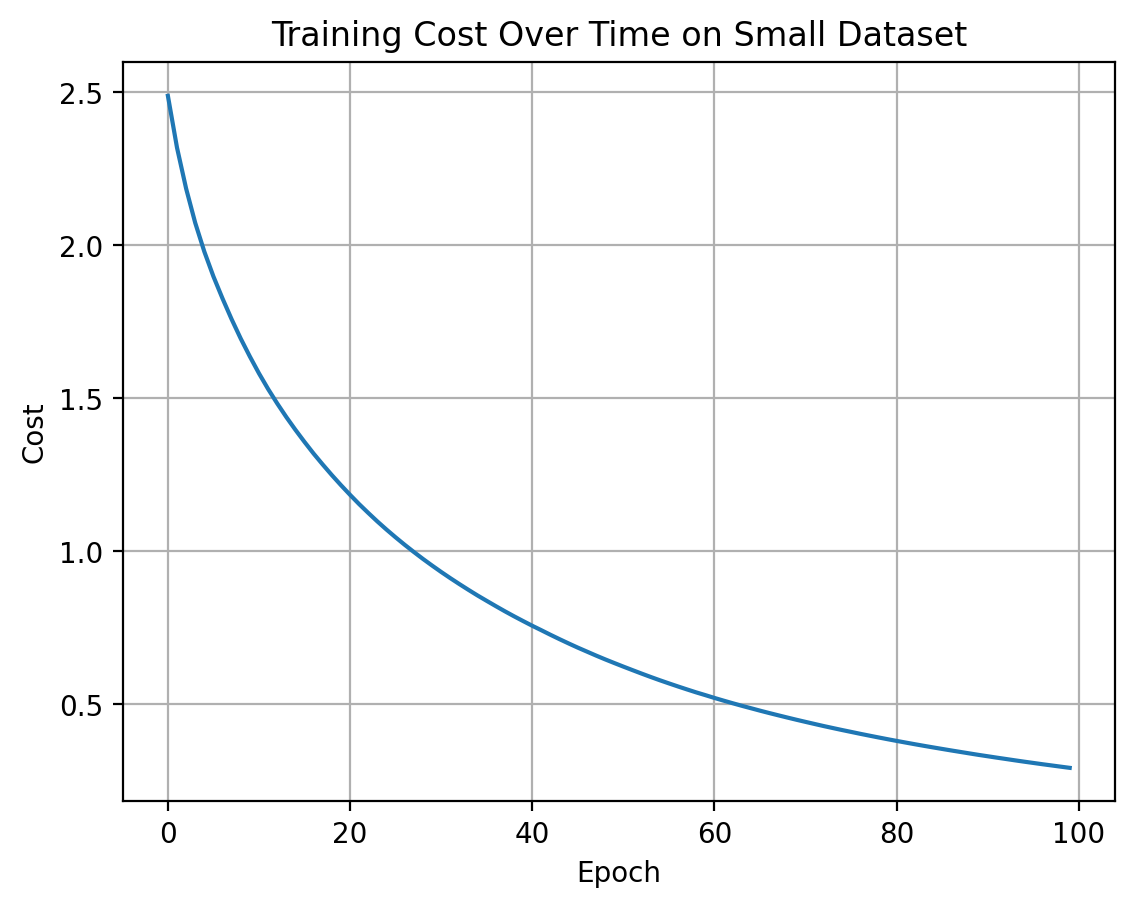

In [30]:
# Initialize PdfPages context manager
with PdfPages('Report-Assignment_2.pdf') as pdf:
#Analyze the network
  plt.plot(training_costs)
  plt.xlabel('Epoch')
  plt.ylabel('Cost')
  plt.title('Training Cost Over Time on Small Dataset')
  plt.grid(True)

  # Save the current figure into the PDF before showing it
  pdf.savefig()  # Save the current figure into the PDF
  plt.show()
  plt.close()  # Close the figure to free up memory

Looking at the results and the graph, we can conclude that the cost is consistently decreasing across epochs.
It indicates that the model is learning from the small dataset, the gradients are likely being computed correctly, and the mini-batch gradient descent algorithm is functioning as it should.

##Takeaways:
1. The cost significantly decreases from about 2.49 to 0.11 over 200 epochs.
2. Achieving very low training loss indicates that the network has enough capacity to memorize the training data leading to overfit. This is the goal here, so the test is successful.
3. The plot curve shows leveling off of the cost as it approaches closer to zero, suggesting diminishing returns from further training on this dataset - great indicator of overfitting.



#Exercise 3: Train your network with cyclical learning rates

We explore the concept of cyclic learning rates within the training loop with **mini-batch Gradient descent**.

This technique is designed to systematically vary the learning rate between an upper and lower bound rather than keeping it constant or monotically decreasing it. This aims to escape local minima more effectively and potentially speed up convergence.

For the cyclic learning part, we choose the following parameters:

*   eta_min = 1e-5
*   eta_max = 1e-1
*   n_s = 500

For mini-batch gradient, we choose:
*   Batch size = 100


##Steps followed in the training loop:
1. Mini-batch Extraction
2. Forward Pass
3. Cost Computation
4. Backward Pass
5. Parameter Update
6. Learning Rate Update

In [31]:
def get_cyclic_lr(t, eta_min=1e-5, eta_max=1e-1, ns=500):
  """
  Compute the learning rate for the current iteration 't'
  t: epoch counter
  ns: stepsize
  """
  #Compute the cycle count
  cycle = np.floor(1 + t /(2*ns))
  x = np.abs((t / ns) - 2 * cycle + 1)
  eta_t = eta_min + (eta_max - eta_min) * np.maximum(0, (1-x)) # learning rate
  return eta_t


def get_cyclic_lr_new(t, eta_min=1e-5, eta_max=1e-1, ns=500):
    l = int(t / (2 * ns))
    # if even cycle increase lr, if odd cycle decrease lr
    if 2 * l * ns <= t <= (2 * l + 1) * ns:
        return eta_min + (t - 2 * l * ns) / ns * (eta_max - eta_min)
    if (2 * l + 1) * ns <= t <= 2 * ns * (l + 1):
        return eta_max - (t - (2 * l + 1) * ns) / ns * (eta_max - eta_min)


def train_with_cyclic_lr(X, Y, params, epochs, batch_size, ns, lambda_ = 0):
  m = X.shape[1] #total number of training examples
  num_minibatches = m // batch_size #floor division
  costs = []
  losses = [] #Track loss values
  accuracies = [] #Track accuracy values
  learning_rates = [] #Track learning rates - DEBUG


  #Initial learning rate
  eta_t = get_cyclic_lr(0)
  t = 0

  for epoch in range(epochs):
    epoch_cost = 0
    correct_predictions = 0

    idxs = np.random.permutation(m)
    X = X[:, idxs]
    Y = Y[:, idxs]

    for i in range(num_minibatches):
      #Get minibatch
      begin = i * batch_size
      end = min(begin + batch_size, m)
      X_mini = X[:, begin:end]
      Y_mini = Y[:, begin:end]

      learning_rates.append(eta_t)


      #Forward pass
      P, cache = forward_pass(X_mini, params)

      #Compute cost
      mini_batch_cost = compute_cost(Y_mini, P, params, lambda_)
      epoch_cost += mini_batch_cost

      #Compute loss
      mini_batch_loss = compute_loss(Y_mini, P)
      losses.append(mini_batch_loss)

      #Backward pass
      grads = backward_pass(Y_mini, cache, params)

      #Compute accuracuy
      # Compute the number of correct predictions for the mini-batch
      mini_batch_correct_predictions = np.sum(np.argmax(P, axis=0) == np.argmax(Y_mini, axis=0))
      correct_predictions += mini_batch_correct_predictions


      #Update each parameter according to its gradient and the current learning rate
      for key in params.keys():
        params[key] -= eta_t * grads[key]

      #Update learning rate according to cyclical schedule
      t += 1
      eta_t = get_cyclic_lr(t, eta_min=1e-5, eta_max=1e-1, ns=ns)
      #print(f"Current Learning rate at time {t} is {eta_t}")


    #Average cost for the epoch
    epoch_cost_avg = epoch_cost / num_minibatches
    epoch_accuracy = correct_predictions / m

    costs.append(epoch_cost)
    accuracies.append(epoch_accuracy)
    print(f'Epoch {epoch+1} Cost: {epoch_cost_avg}, Accuracy: {epoch_accuracy}')

  return params, costs, losses, accuracies, learning_rates


In [32]:
X.shape

(8, 5)

Setting the hyperparametrs and starting the learning loop

Epoch 1 Cost: 2.297335040248491, Accuracy: 0.1669
Epoch 2 Cost: 1.9611133046339102, Accuracy: 0.3023
Epoch 3 Cost: 1.7947513786185367, Accuracy: 0.3742
Epoch 4 Cost: 1.6814938678120706, Accuracy: 0.4121
Epoch 5 Cost: 1.6080046323882558, Accuracy: 0.4376
Epoch 6 Cost: 1.5515386037211838, Accuracy: 0.4539
Epoch 7 Cost: 1.501672540747738, Accuracy: 0.4712
Epoch 8 Cost: 1.4644957878966005, Accuracy: 0.4877
Epoch 9 Cost: 1.419174633991818, Accuracy: 0.508
Epoch 10 Cost: 1.3892626566623136, Accuracy: 0.5233
Epoch 11 Cost: 1.3587580866352753, Accuracy: 0.5306
Epoch 12 Cost: 1.335976050842713, Accuracy: 0.5425
Epoch 13 Cost: 1.3072353562565144, Accuracy: 0.5513
Epoch 14 Cost: 1.293025844400831, Accuracy: 0.5552
Epoch 15 Cost: 1.262568474164666, Accuracy: 0.565
Epoch 16 Cost: 1.2533397971669669, Accuracy: 0.5677
Epoch 17 Cost: 1.230707699677158, Accuracy: 0.574
Epoch 18 Cost: 1.2079573563522288, Accuracy: 0.5852
Epoch 19 Cost: 1.2341912264254418, Accuracy: 0.5837
Epoch 20 Cost: 1.20158303005046

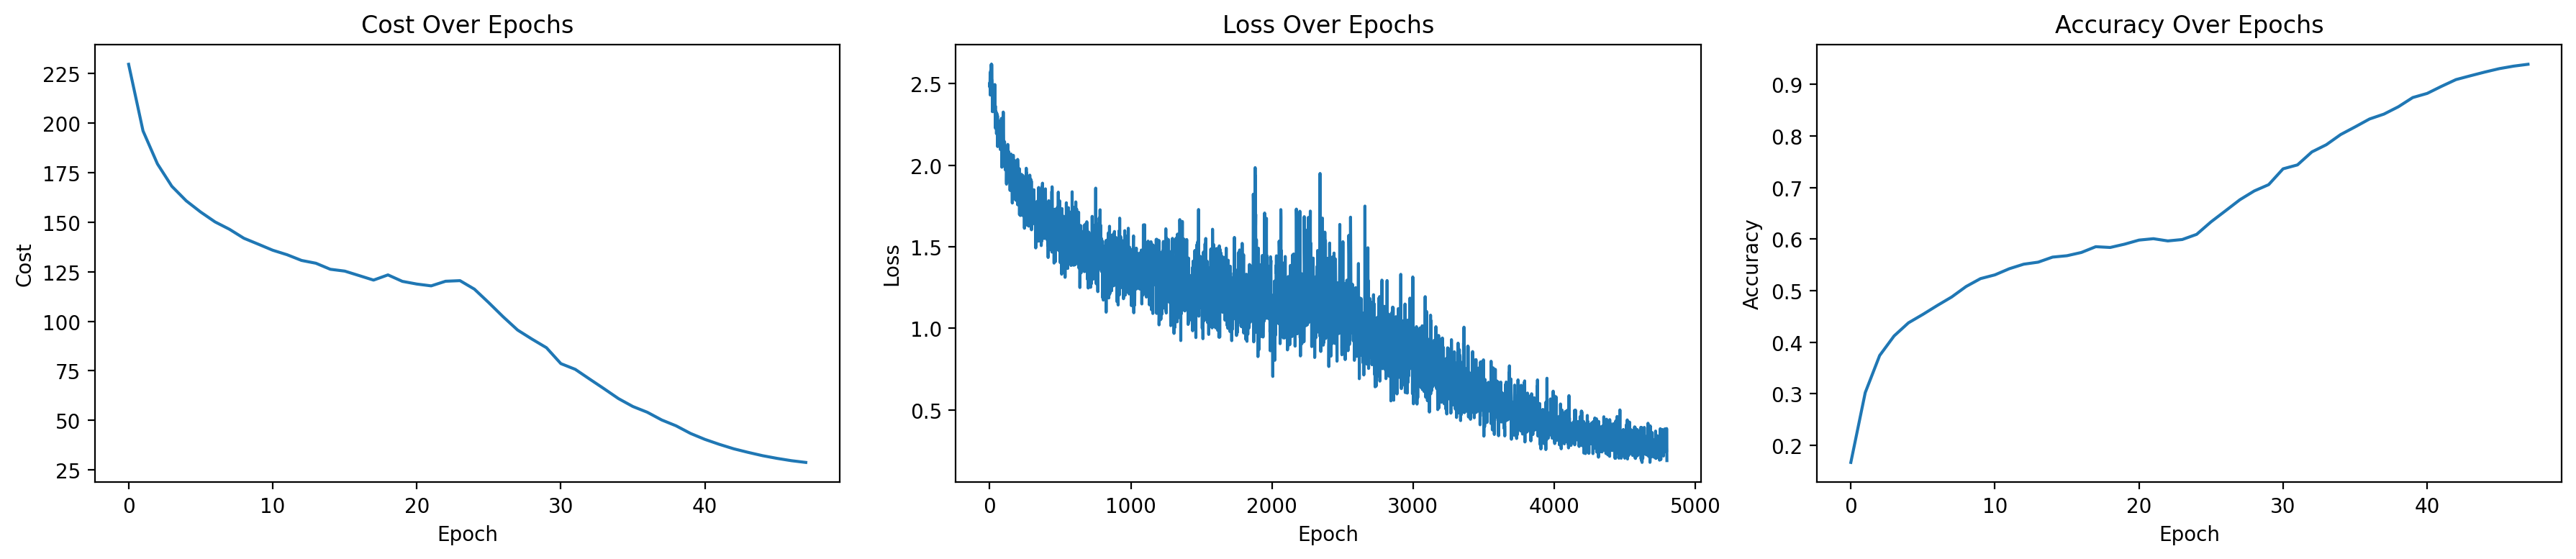

In [33]:
import math
#Hyperparameters
epochs = 48
batch_size = 100
lambda_ = 0.01

m = train_X.shape[1] # The number of training examples
num_minibatches = m // batch_size
# Calculate ns dynamically
cycles = 1
total_iterations = epochs * num_minibatches
iterations_per_cycle = total_iterations / cycles
ns = int(iterations_per_cycle / 2)

input_dim = 3072 #the number of input features
hidden_dim = 50 #the number of hidden layers
output_dim = 10 #the number of output classes

#Initiailze the network parameters
params = initialize_parameters(input_dim, hidden_dim, output_dim)

#Call the training function
trained_params, training_costs, training_losses, training_accuracies, lrs = train_with_cyclic_lr(
    train_X,
    train_Y,
    params,
    epochs=epochs,
    batch_size=batch_size,
    ns=ns,
    lambda_=lambda_
)

with PdfPages('Report-Assignment_2.pdf') as pdf:
  # Plotting the training costs, losses, and accuracies
  plt.figure(figsize=(18, 4))

  plt.subplot(1, 3, 1)
  plt.plot(training_costs)
  plt.title('Cost Over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Cost')

  plt.subplot(1, 3, 2)
  plt.plot(training_losses)
  plt.title('Loss Over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

  plt.subplot(1, 3, 3)
  plt.plot(training_accuracies)
  plt.title('Accuracy Over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')

  """plt.subplot(1, 4, 4)
  plt.plot(lrs)
  plt.title('Learning Rates Over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Learning Rate')
  """
  plt.tight_layout()
  # Save the current figure into the PDF before showing it
  pdf.savefig()  # Save the current figure into the PDF
  plt.show()
  plt.close()  # Close the figure to free up memory

#Exercise 4: Train your network for real

##Dataset:
First we prepare the data. According to the instructions, we must load all training batches for training except 5000 images that should be used as the validation set.



In [34]:
def loadAllBatches(batch_folder):
  #define the base file name pattern
  base_filename = "data_batch_"

  #List to store X and Y arrays
  X_list = []
  Y_list = []

  #Loop through the batch numbers
  for i in range (1, 6):
    #Construct the full path for each batch file
    batch_file = os.path.join(batch_folder, f"{base_filename}{i}")

    #Load the batch
    X, Y, y = loadBatch(batch_file)
    #Append the loaded data to the lists
    X_list.append(X)
    Y_list.append(Y)

  #Concatenate all batches
  X_all = np.concatenate(X_list, axis=1)
  Y_all = np.concatenate(Y_list, axis=1)
  return X_all, Y_all

def split_data(X, Y, num_validation=5000):
    shuffled_indices = np.random.permutation(X.shape[1])
    X_train = X[:, shuffled_indices[num_validation:]]
    Y_train = Y[:, shuffled_indices[num_validation:]]
    X_val = X[:, shuffled_indices[:num_validation]]
    Y_val = Y[:, shuffled_indices[:num_validation]]
    return X_train, Y_train, X_val, Y_val

def normalize_data(X_train, X_val, X_test):
    # Calculate mean and std from the training data
    mean = np.mean(X_train, axis=1, keepdims=True)
    std = np.std(X_train, axis=1, keepdims=True)

    # Normalize training, validation, and test data
    X_train = (X_train - mean) / std
    X_val = (X_val - mean) / std
    X_test = (X_test - mean) / std

    return X_train, X_val, X_test

In [35]:
import random
#Load and prepare
random.seed(24)
batch_folder = '/content/cifar-10-batches-py'
X_all, Y_all = loadAllBatches(batch_folder)
X_train, Y_train, X_val, Y_val = split_data(X_all, Y_all)

# Normalize the data
X_train, X_val, test_X = normalize_data(X_train, X_val, test_X)

print(f"\nShape of X_train: {X_train.shape}")
print(f"Shape of Y_train: {Y_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of Y_val: {Y_val.shape}")

print(f"Shape of test_X: {test_X.shape}")
print(f"Shape of test_Y: {test_Y.shape}")


Shape of X_train: (3072, 45000)
Shape of Y_train: (10, 45000)
Shape of X_val: (3072, 5000)
Shape of Y_val: (10, 5000)
Shape of test_X: (3072, 10000)
Shape of test_Y: (10, 10000)


## Cycles
We will run the training for more cycles, say 3 and for a larger n_s=800.

## Optimization of regularization term, lambda
So far we have not optimized the value of regularization term lambda at all. Now we will use "**Coarse-to-fine**" random search to set lambda.

More data and increasing the value of lambda are both forms of regularization. When you have less train- ing data you will need a higher lambda and when you have more training data you will need a lower lambda.

In order to get a good idea of the peformance of a labmda, we will run 2 cycles of training and setting $$n_s = 2 floor(\frac{n}{n\_{batch}})$$


Searching for lambda on a log-scale:

to generate one random sample for the learning rate uniformly in the range of 10^l min to 10^l max

```
l = lmin + (lmax - lmin)*rand(1, 1);
lambda = 10^l;
```







Updated training function which uses lambda when calculating the costs

---



In [28]:
# Vary lambda - in a coarse fashion over a broad range of values
  # Train the network from a random initializtion
  # Measure its performance for each lambda



In [36]:
import numpy as np
import matplotlib.pyplot as plt


def train_with_cyclic_lr_val(X_train, Y_train, X_val, Y_val, X_test, Y_test, params, epochs, batch_size, ns, lambda_=0):
    m = X_train.shape[1]  # Total number of examples
    mm = X_val.shape[1]
    num_minibatches = m // batch_size
    costs = []
    losses = []
    accuracies = []
    val_costs = []
    val_losses = []
    val_accuracies = []
    #test_accuracies = [] # we'll also report test accuracies with each epoch
    t = 0

    for epoch in range(epochs):
        epoch_cost = 0
        correct_predictions = 0
        #test_accuracies = 0
        # DEBUG

        idxs = np.random.permutation(m)
        X_train = X_train[:, idxs]
        Y_train = Y_train[:, idxs]

        for i in range(num_minibatches):
            begin = i * batch_size
            end = min(begin + batch_size, m)
            X_mini = X_train[:, begin:end]
            Y_mini = Y_train[:, begin:end]

            # Forward pass
            P, cache = forward_pass(X_mini, params)

            # Compute training metrics
            mini_batch_cost = compute_cost(Y_mini, P, params, lambda_)
            mini_batch_loss = compute_loss(Y_mini, P)
            mini_batch_accuracy = np.mean(np.argmax(P, axis=0) == np.argmax(Y_mini, axis=0))
            mini_batch_correct_predictions = np.sum(np.argmax(P, axis=0) == np.argmax(Y_mini, axis=0))
            correct_predictions += mini_batch_correct_predictions  # Update the total count of correct predictions

            epoch_cost += mini_batch_cost

            # ON test data:
            #P_test, _ = forward_pass(X_test, params)
            #test_accuracy = np.mean(np.argmax(P_test, axis=0) == np.argmax(Y_test, axis=0))


            # Backward pass and update
            grads = backward_pass(Y_mini, cache, params)
            t = t+1 #epoch * num_minibatches + i
            eta_t = get_cyclic_lr(t, ns=ns)
            for key in params.keys():
                params[key] -= eta_t * grads[key]

            # Record metrics at specified intervals
            if i % (num_minibatches // 10) == 0 or i == num_minibatches - 1:  # Evaluate periodically and at the last minibatch
                costs.append(mini_batch_cost)
                losses.append(mini_batch_loss)
                accuracies.append(mini_batch_accuracy)

                # Evaluate on validation set
                val_P, _ = forward_pass(X_val, params)
                val_cost = compute_cost(Y_val, val_P, params, lambda_)
                val_loss = compute_loss(Y_val, val_P)
                val_accuracy = np.mean(np.argmax(val_P, axis=0) == np.argmax(Y_val, axis=0))

                #TEST ACCURACY -- START
                P_test, _ = forward_pass(X_test, params)
                test_accuracy = np.mean(np.argmax(P_test, axis=0) == np.argmax(Y_test, axis=0))
                #print(f"Test accuracy: {test_accuracy}")
                #TEST ACCURACY -- END

                val_costs.append(val_cost)
                val_losses.append(val_loss)
                val_accuracies.append(val_accuracy)


        print(f"Epoch {epoch+1}/{epochs} | Cost: {epoch_cost / num_minibatches:.4f} | Training Accuracy: {correct_predictions / m:.4f} | Test Accuracy: {test_accuracy:.4f}")

    # Plotting the results
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(costs, label='Training Cost')
    plt.plot(val_costs, label='Validation Cost', linestyle='--')
    plt.title('Training and Validation Cost')
    plt.xlabel('Number of Evaluations')
    plt.ylabel('Cost')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss', linestyle='--')
    plt.title('Training and Validation Loss')
    plt.xlabel('Number of Evaluations')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy', linestyle='--')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Number of Evaluations')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return params, costs, losses, accuracies, val_costs, val_losses, val_accuracies



##Coarse search over Lambda



Starting training with Lambda: 0.000010
Epoch 1/48 | Cost: 1.9810 | Training Accuracy: 0.2951 | Test Accuracy: 0.3746
Epoch 2/48 | Cost: 1.6569 | Training Accuracy: 0.4204 | Test Accuracy: 0.4127
Epoch 3/48 | Cost: 1.5682 | Training Accuracy: 0.4500 | Test Accuracy: 0.4353
Epoch 4/48 | Cost: 1.5077 | Training Accuracy: 0.4719 | Test Accuracy: 0.4368
Epoch 5/48 | Cost: 1.4690 | Training Accuracy: 0.4834 | Test Accuracy: 0.4533
Epoch 6/48 | Cost: 1.4515 | Training Accuracy: 0.4895 | Test Accuracy: 0.4235
Epoch 7/48 | Cost: 1.4443 | Training Accuracy: 0.4937 | Test Accuracy: 0.4237
Epoch 8/48 | Cost: 1.4550 | Training Accuracy: 0.4863 | Test Accuracy: 0.4289
Epoch 9/48 | Cost: 1.4204 | Training Accuracy: 0.5016 | Test Accuracy: 0.4419
Epoch 10/48 | Cost: 1.3426 | Training Accuracy: 0.5279 | Test Accuracy: 0.4127
Epoch 11/48 | Cost: 1.2859 | Training Accuracy: 0.5486 | Test Accuracy: 0.4367
Epoch 12/48 | Cost: 1.2343 | Training Accuracy: 0.5671 | Test Accuracy: 0.4369
Epoch 13/48 | Cost: 

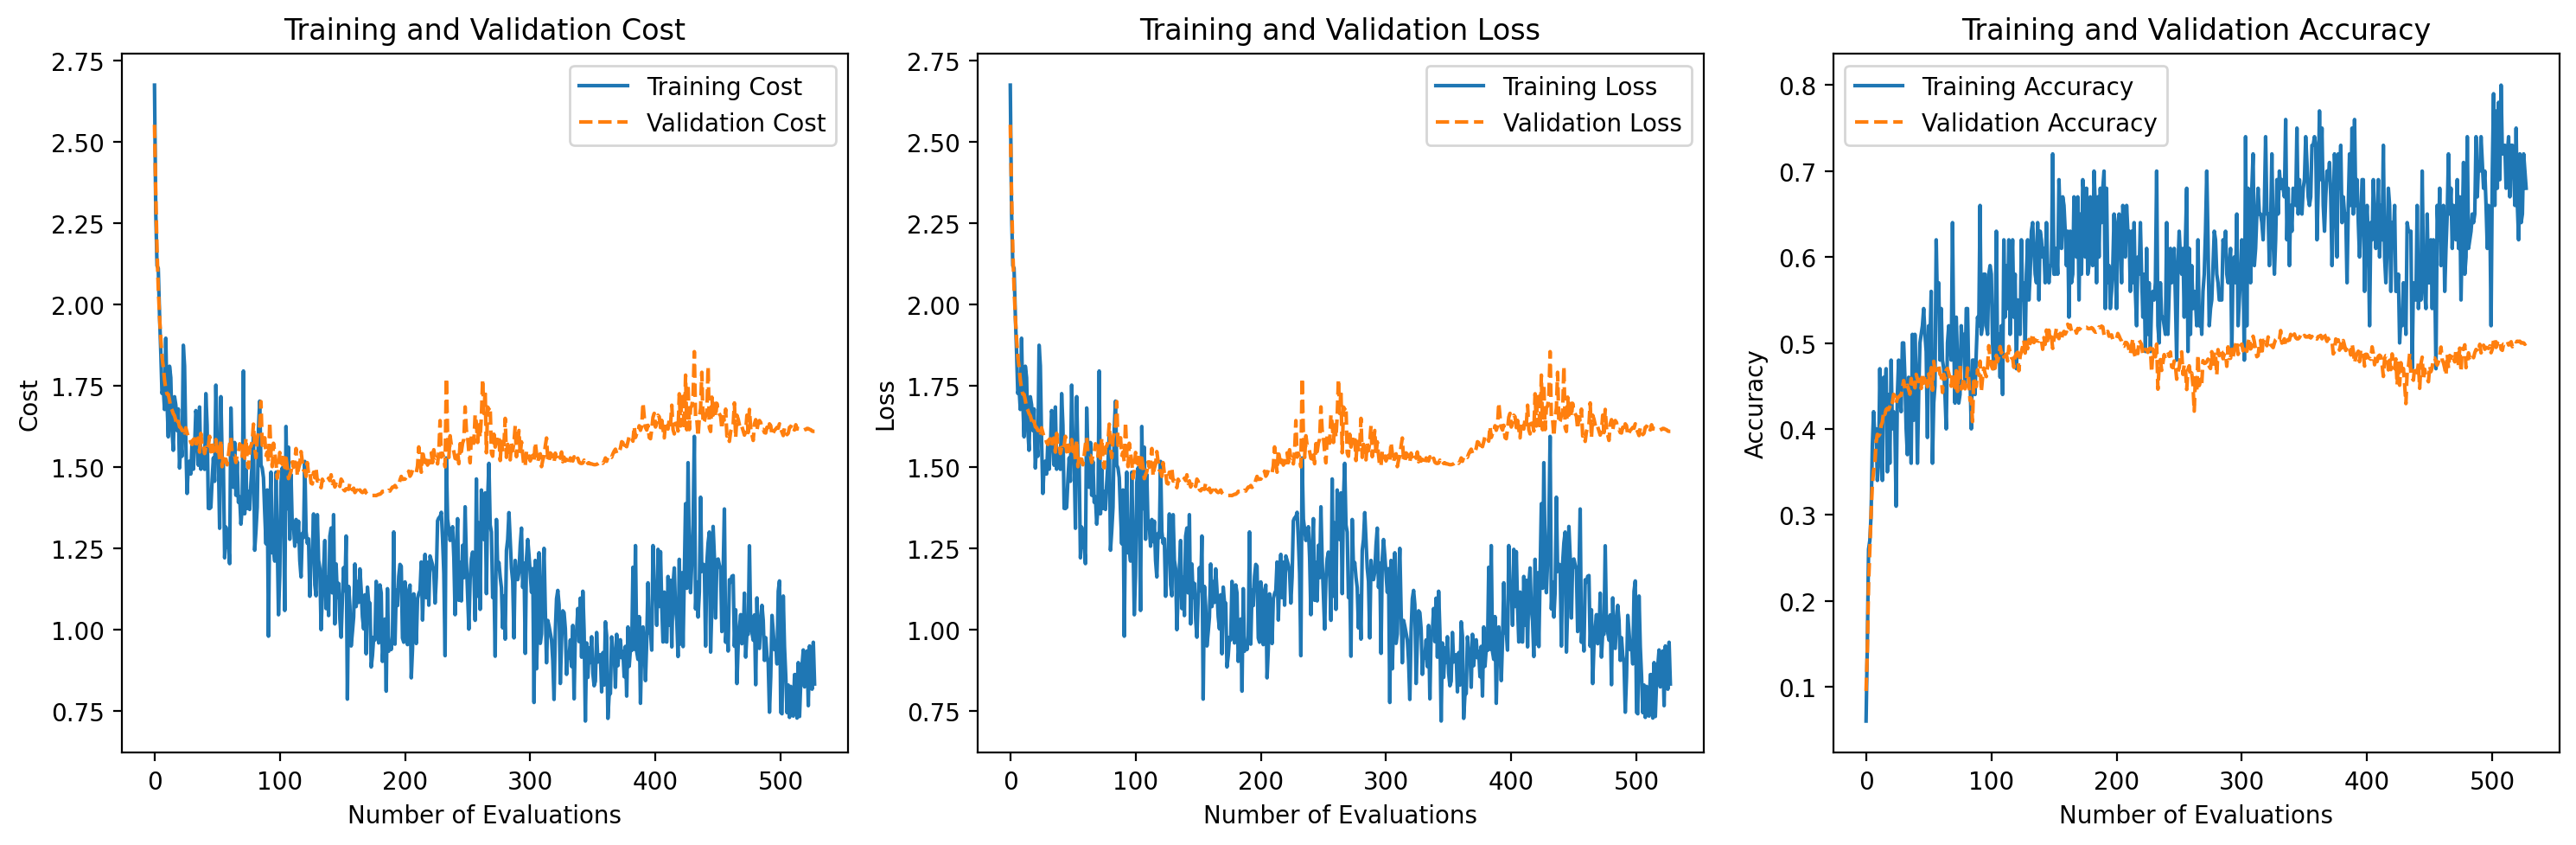

Lambda: 0.000010, Validation Accuracy: 0.5004

Starting training with Lambda: 0.001000
Epoch 1/48 | Cost: 1.9813 | Training Accuracy: 0.2950 | Test Accuracy: 0.3742
Epoch 2/48 | Cost: 1.6571 | Training Accuracy: 0.4203 | Test Accuracy: 0.4128
Epoch 3/48 | Cost: 1.5683 | Training Accuracy: 0.4516 | Test Accuracy: 0.4348
Epoch 4/48 | Cost: 1.5083 | Training Accuracy: 0.4717 | Test Accuracy: 0.4360
Epoch 5/48 | Cost: 1.4689 | Training Accuracy: 0.4857 | Test Accuracy: 0.4537
Epoch 6/48 | Cost: 1.4528 | Training Accuracy: 0.4882 | Test Accuracy: 0.4244
Epoch 7/48 | Cost: 1.4454 | Training Accuracy: 0.4939 | Test Accuracy: 0.4239
Epoch 8/48 | Cost: 1.4570 | Training Accuracy: 0.4875 | Test Accuracy: 0.4207
Epoch 9/48 | Cost: 1.4215 | Training Accuracy: 0.5029 | Test Accuracy: 0.4325
Epoch 10/48 | Cost: 1.3453 | Training Accuracy: 0.5287 | Test Accuracy: 0.4143
Epoch 11/48 | Cost: 1.2890 | Training Accuracy: 0.5474 | Test Accuracy: 0.4408
Epoch 12/48 | Cost: 1.2367 | Training Accuracy: 0.568

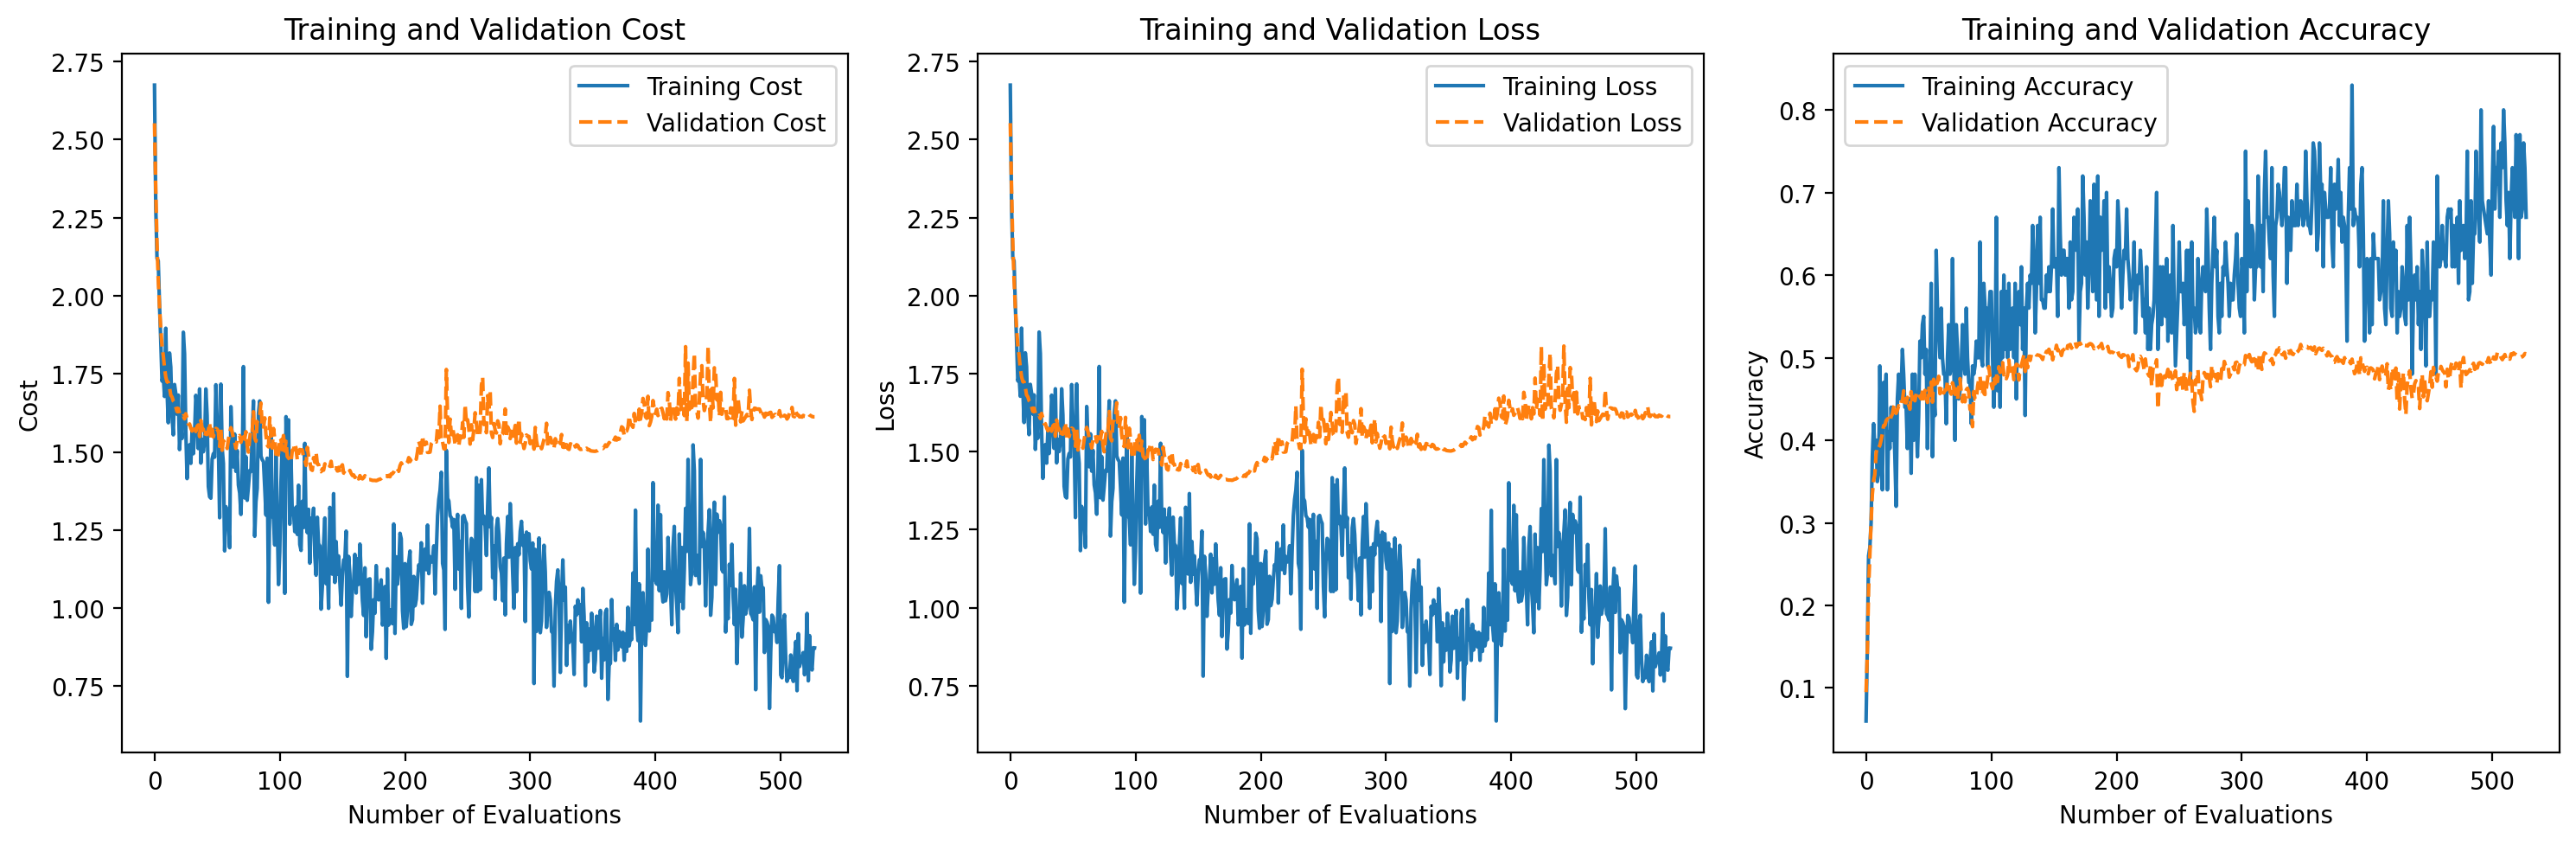

Lambda: 0.001000, Validation Accuracy: 0.5046

Starting training with Lambda: 0.100000
Epoch 1/48 | Cost: 2.0109 | Training Accuracy: 0.2947 | Test Accuracy: 0.3728
Epoch 2/48 | Cost: 1.6873 | Training Accuracy: 0.4190 | Test Accuracy: 0.4125
Epoch 3/48 | Cost: 1.5993 | Training Accuracy: 0.4504 | Test Accuracy: 0.4350
Epoch 4/48 | Cost: 1.5400 | Training Accuracy: 0.4706 | Test Accuracy: 0.4349
Epoch 5/48 | Cost: 1.5040 | Training Accuracy: 0.4853 | Test Accuracy: 0.4543
Epoch 6/48 | Cost: 1.4890 | Training Accuracy: 0.4875 | Test Accuracy: 0.4252
Epoch 7/48 | Cost: 1.4857 | Training Accuracy: 0.4915 | Test Accuracy: 0.4215
Epoch 8/48 | Cost: 1.4997 | Training Accuracy: 0.4873 | Test Accuracy: 0.4150
Epoch 9/48 | Cost: 1.4702 | Training Accuracy: 0.5002 | Test Accuracy: 0.4404
Epoch 10/48 | Cost: 1.4007 | Training Accuracy: 0.5252 | Test Accuracy: 0.4137
Epoch 11/48 | Cost: 1.3475 | Training Accuracy: 0.5450 | Test Accuracy: 0.4382
Epoch 12/48 | Cost: 1.3023 | Training Accuracy: 0.558

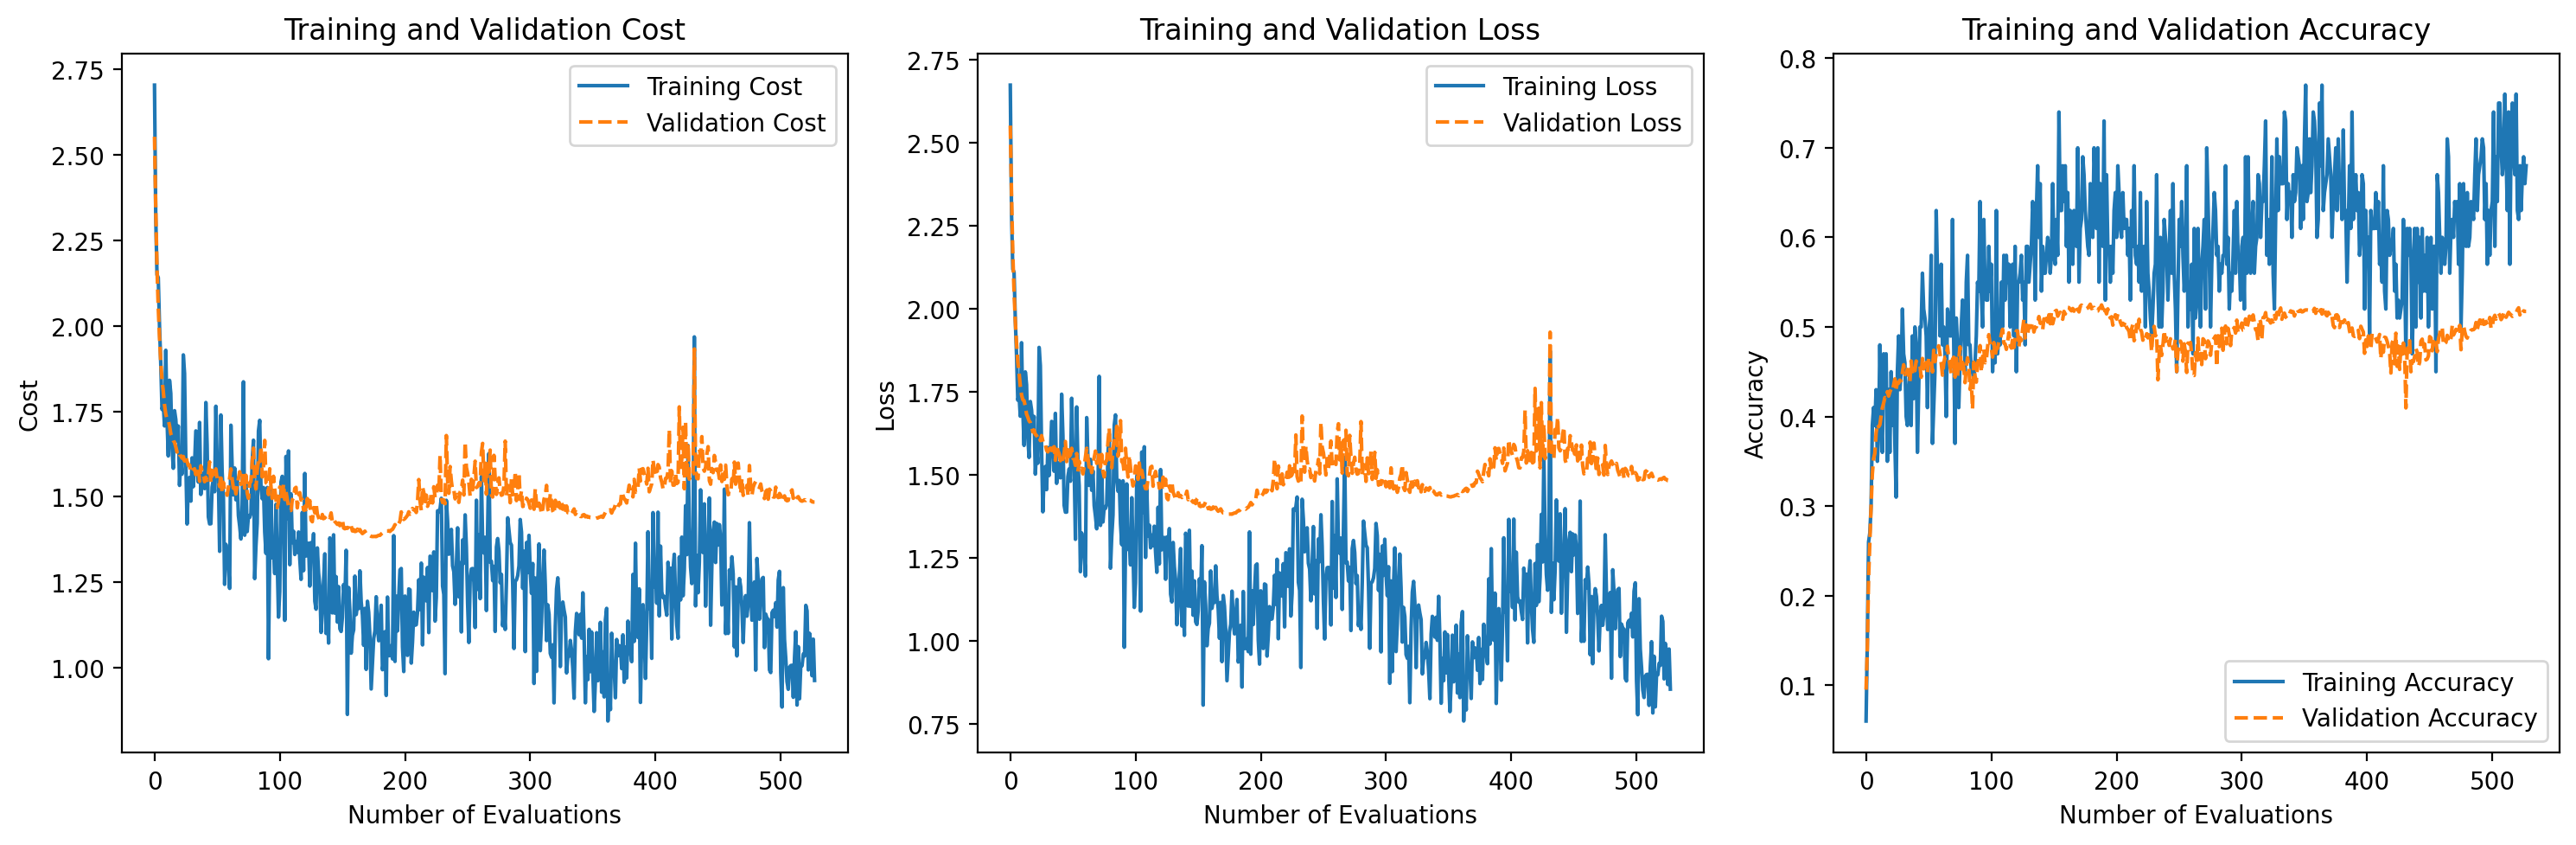

Lambda: 0.100000, Validation Accuracy: 0.5174


In [30]:
epochs = 48 #100 # Set according to training strategy
batch_size = 100
#ns = 900

cycles = 3
num_minibatches = X_train.shape[1] // batch_size
total_iterations = epochs * num_minibatches
iterations_per_cycle = total_iterations / cycles
ns = int(iterations_per_cycle / 2)



#log scale for lambda search
lmin, lmax = -5, -1
lambdas = np.logspace(lmin, lmax, num=3) #CORASE SEARCH: create 3 values between 10^lmin and 10^lmax

results = []
for lambda_ in lambdas:
  params = initialize_parameters(3072, 50, 10) # Fixed!!

  print(f"\nStarting training with Lambda: {lambda_:.6f}")
  params, train_costs, train_losses, train_accuracies, val_costs, val_losses, val_accuracies = train_with_cyclic_lr_val(
      X_train, Y_train, X_val, Y_val, test_X, test_Y, params, epochs, batch_size, ns, lambda_)
  final_accuracy = val_accuracies[-1]
  results.append((lambda_, final_accuracy))
  print(f"Lambda: {lambda_:.6f}, Validation Accuracy: {final_accuracy}")




## Fine search for Lambda


Starting training with Lambda: 0.000010
Epoch 1/48 | Cost: 1.9810 | Training Accuracy: 0.2951 | Test Accuracy: 0.3746
Epoch 2/48 | Cost: 1.6569 | Training Accuracy: 0.4204 | Test Accuracy: 0.4127
Epoch 3/48 | Cost: 1.5682 | Training Accuracy: 0.4500 | Test Accuracy: 0.4353
Epoch 4/48 | Cost: 1.5077 | Training Accuracy: 0.4719 | Test Accuracy: 0.4368
Epoch 5/48 | Cost: 1.4690 | Training Accuracy: 0.4834 | Test Accuracy: 0.4533
Epoch 6/48 | Cost: 1.4515 | Training Accuracy: 0.4895 | Test Accuracy: 0.4235
Epoch 7/48 | Cost: 1.4443 | Training Accuracy: 0.4937 | Test Accuracy: 0.4237
Epoch 8/48 | Cost: 1.4550 | Training Accuracy: 0.4863 | Test Accuracy: 0.4289
Epoch 9/48 | Cost: 1.4204 | Training Accuracy: 0.5016 | Test Accuracy: 0.4419
Epoch 10/48 | Cost: 1.3426 | Training Accuracy: 0.5279 | Test Accuracy: 0.4127
Epoch 11/48 | Cost: 1.2859 | Training Accuracy: 0.5486 | Test Accuracy: 0.4367
Epoch 12/48 | Cost: 1.2343 | Training Accuracy: 0.5671 | Test Accuracy: 0.4369
Epoch 13/48 | Cost: 

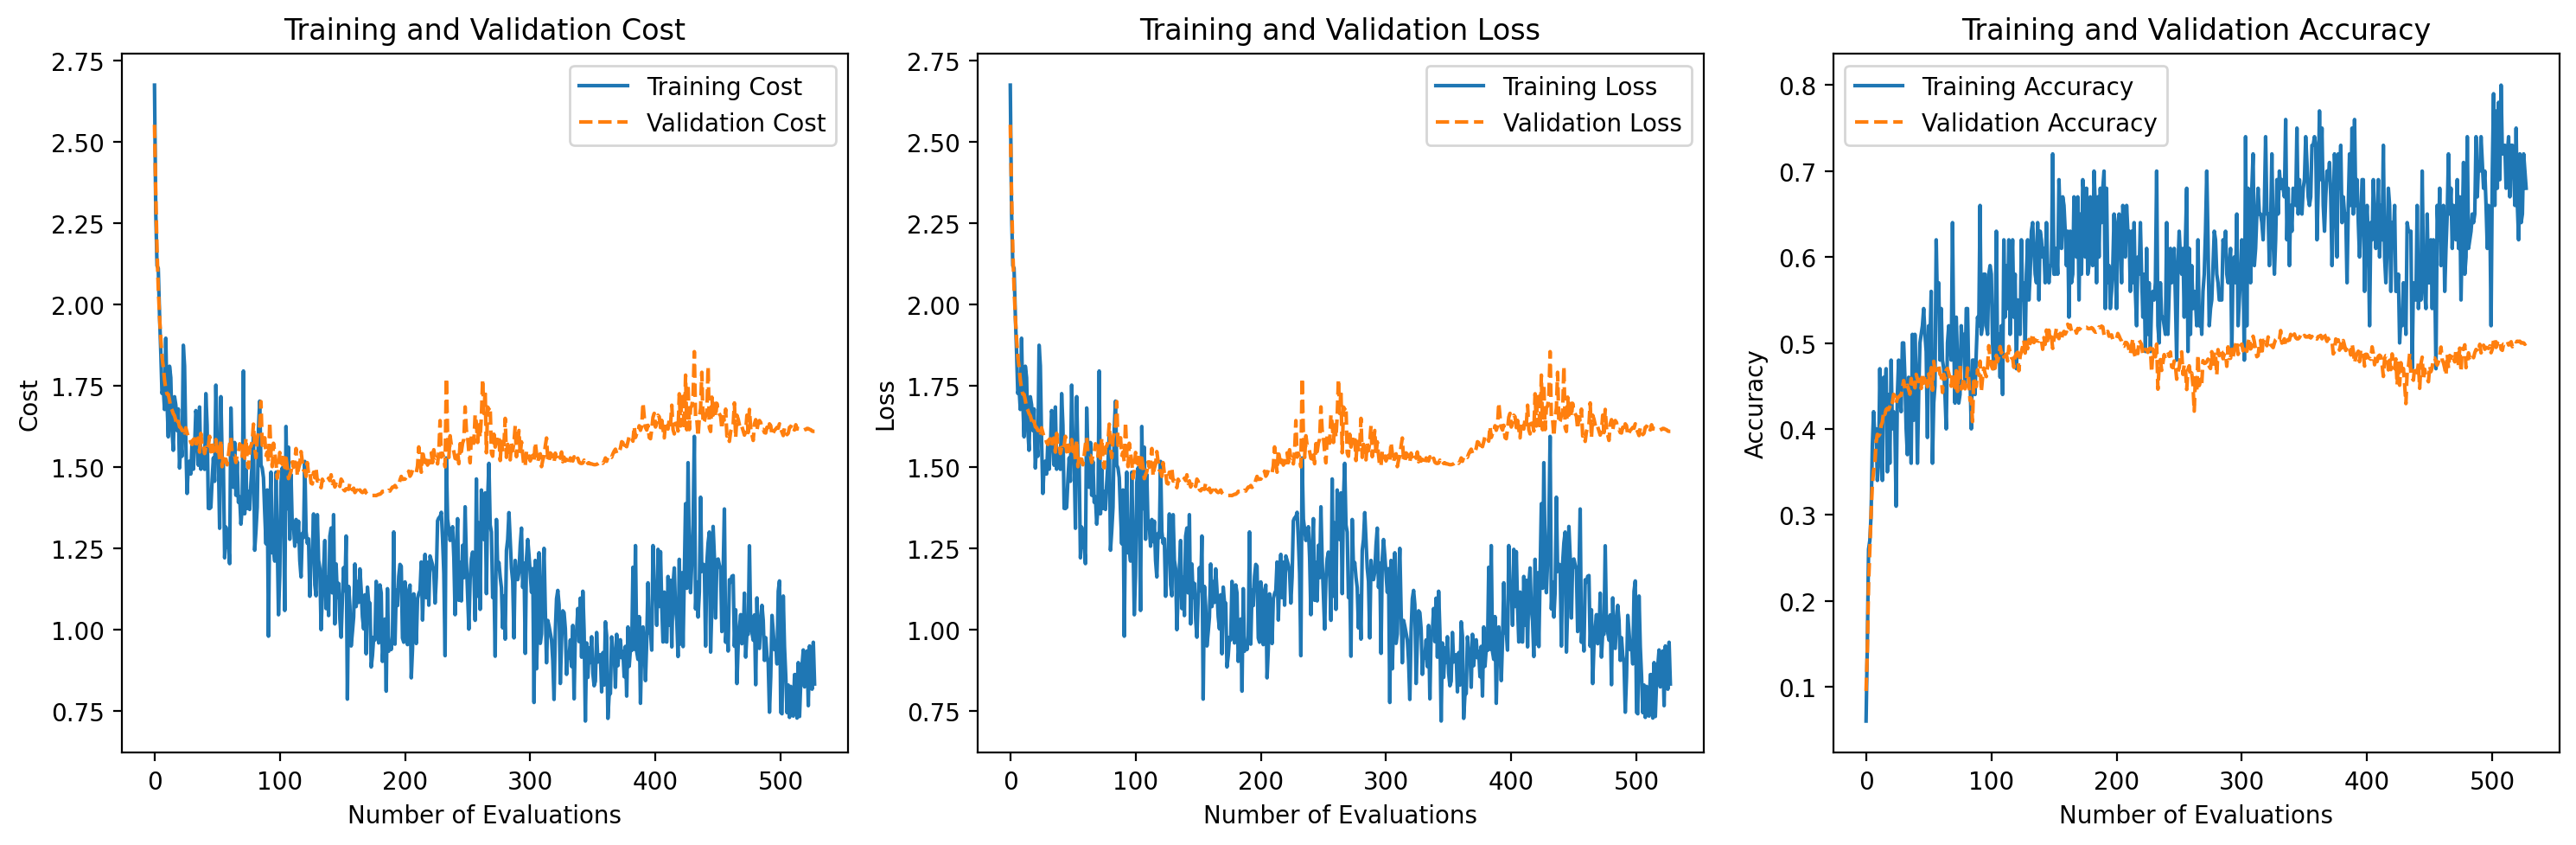

Lambda: 0.000010, Validation Accuracy: 0.5004

Starting training with Lambda: 0.000037
Epoch 1/48 | Cost: 1.9810 | Training Accuracy: 0.2951 | Test Accuracy: 0.3746
Epoch 2/48 | Cost: 1.6569 | Training Accuracy: 0.4204 | Test Accuracy: 0.4127
Epoch 3/48 | Cost: 1.5681 | Training Accuracy: 0.4496 | Test Accuracy: 0.4366
Epoch 4/48 | Cost: 1.5074 | Training Accuracy: 0.4716 | Test Accuracy: 0.4314
Epoch 5/48 | Cost: 1.4680 | Training Accuracy: 0.4844 | Test Accuracy: 0.4570
Epoch 6/48 | Cost: 1.4514 | Training Accuracy: 0.4907 | Test Accuracy: 0.4215
Epoch 7/48 | Cost: 1.4436 | Training Accuracy: 0.4954 | Test Accuracy: 0.4237
Epoch 8/48 | Cost: 1.4519 | Training Accuracy: 0.4892 | Test Accuracy: 0.4260
Epoch 9/48 | Cost: 1.4177 | Training Accuracy: 0.5031 | Test Accuracy: 0.4430
Epoch 10/48 | Cost: 1.3437 | Training Accuracy: 0.5305 | Test Accuracy: 0.4081
Epoch 11/48 | Cost: 1.2851 | Training Accuracy: 0.5486 | Test Accuracy: 0.4391
Epoch 12/48 | Cost: 1.2326 | Training Accuracy: 0.565

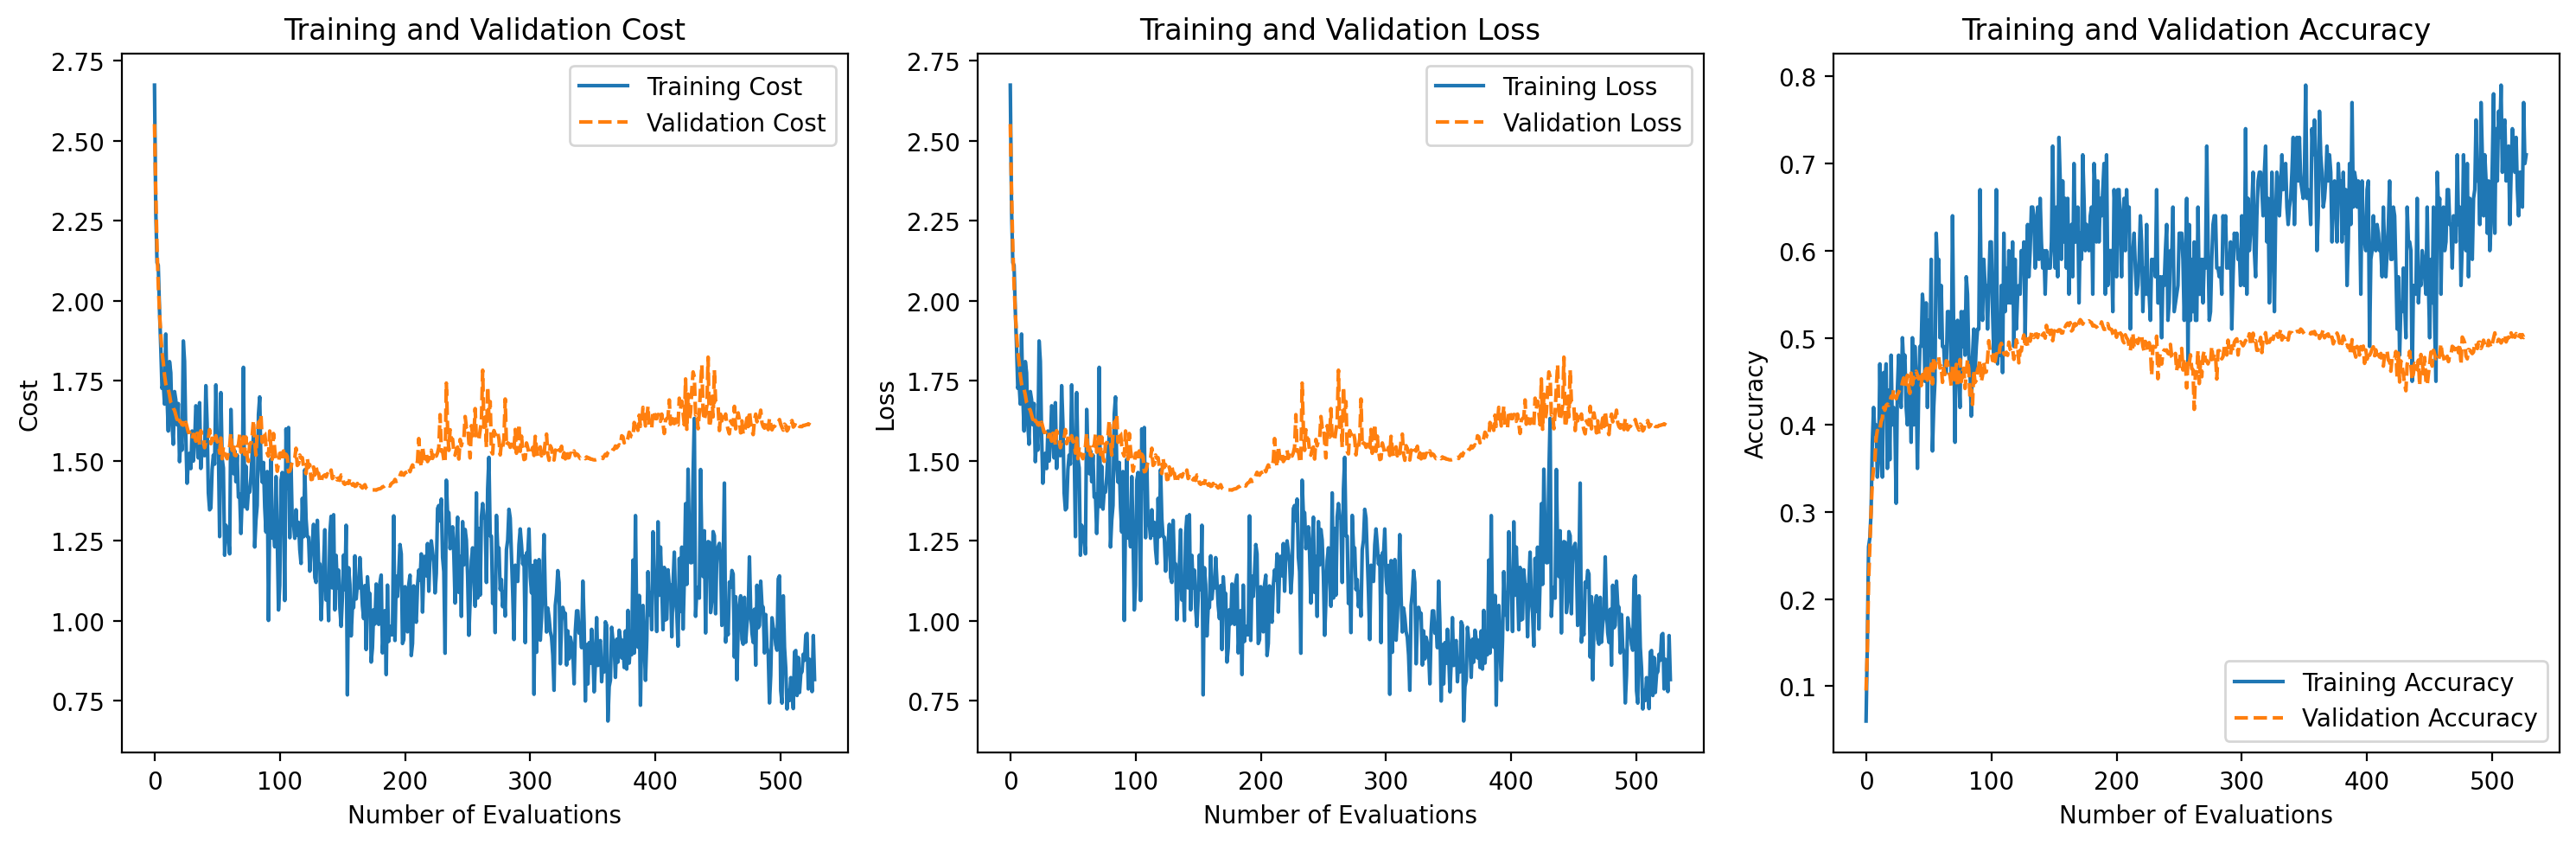

Lambda: 0.000037, Validation Accuracy: 0.4996

Starting training with Lambda: 0.000139
Epoch 1/48 | Cost: 1.9811 | Training Accuracy: 0.2951 | Test Accuracy: 0.3746
Epoch 2/48 | Cost: 1.6568 | Training Accuracy: 0.4208 | Test Accuracy: 0.4121
Epoch 3/48 | Cost: 1.5680 | Training Accuracy: 0.4502 | Test Accuracy: 0.4353
Epoch 4/48 | Cost: 1.5083 | Training Accuracy: 0.4714 | Test Accuracy: 0.4349
Epoch 5/48 | Cost: 1.4695 | Training Accuracy: 0.4846 | Test Accuracy: 0.4574
Epoch 6/48 | Cost: 1.4507 | Training Accuracy: 0.4889 | Test Accuracy: 0.4244
Epoch 7/48 | Cost: 1.4439 | Training Accuracy: 0.4923 | Test Accuracy: 0.4115
Epoch 8/48 | Cost: 1.4562 | Training Accuracy: 0.4878 | Test Accuracy: 0.4273
Epoch 9/48 | Cost: 1.4202 | Training Accuracy: 0.5017 | Test Accuracy: 0.4443
Epoch 10/48 | Cost: 1.3436 | Training Accuracy: 0.5287 | Test Accuracy: 0.4171
Epoch 11/48 | Cost: 1.2857 | Training Accuracy: 0.5475 | Test Accuracy: 0.4372
Epoch 12/48 | Cost: 1.2353 | Training Accuracy: 0.565

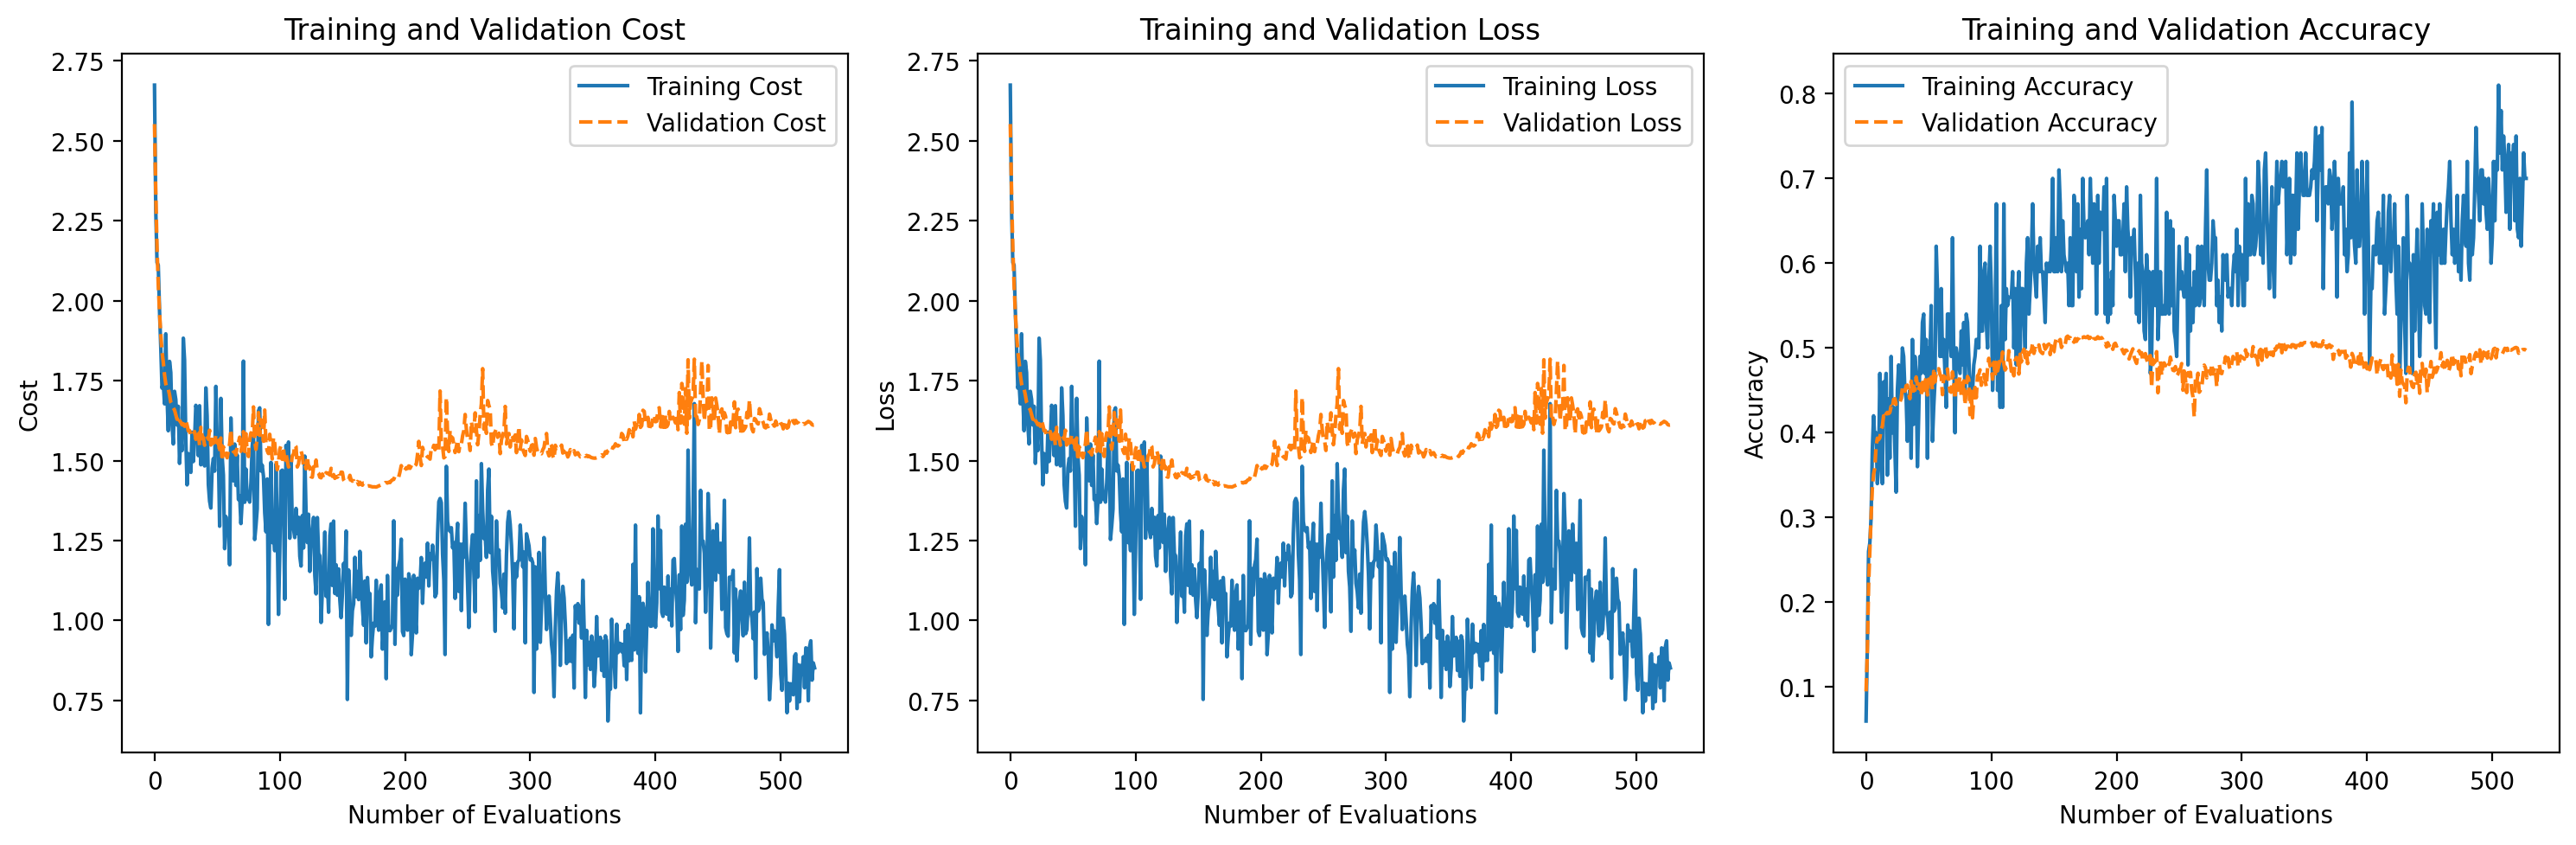

Lambda: 0.000139, Validation Accuracy: 0.4972

Starting training with Lambda: 0.000518
Epoch 1/48 | Cost: 1.9812 | Training Accuracy: 0.2951 | Test Accuracy: 0.3744
Epoch 2/48 | Cost: 1.6568 | Training Accuracy: 0.4196 | Test Accuracy: 0.4136
Epoch 3/48 | Cost: 1.5685 | Training Accuracy: 0.4499 | Test Accuracy: 0.4306
Epoch 4/48 | Cost: 1.5075 | Training Accuracy: 0.4716 | Test Accuracy: 0.4353
Epoch 5/48 | Cost: 1.4672 | Training Accuracy: 0.4838 | Test Accuracy: 0.4561
Epoch 6/48 | Cost: 1.4503 | Training Accuracy: 0.4911 | Test Accuracy: 0.4266
Epoch 7/48 | Cost: 1.4446 | Training Accuracy: 0.4947 | Test Accuracy: 0.4273
Epoch 8/48 | Cost: 1.4549 | Training Accuracy: 0.4883 | Test Accuracy: 0.4243
Epoch 9/48 | Cost: 1.4228 | Training Accuracy: 0.5031 | Test Accuracy: 0.4315
Epoch 10/48 | Cost: 1.3450 | Training Accuracy: 0.5283 | Test Accuracy: 0.4241
Epoch 11/48 | Cost: 1.2868 | Training Accuracy: 0.5483 | Test Accuracy: 0.4371
Epoch 12/48 | Cost: 1.2356 | Training Accuracy: 0.566

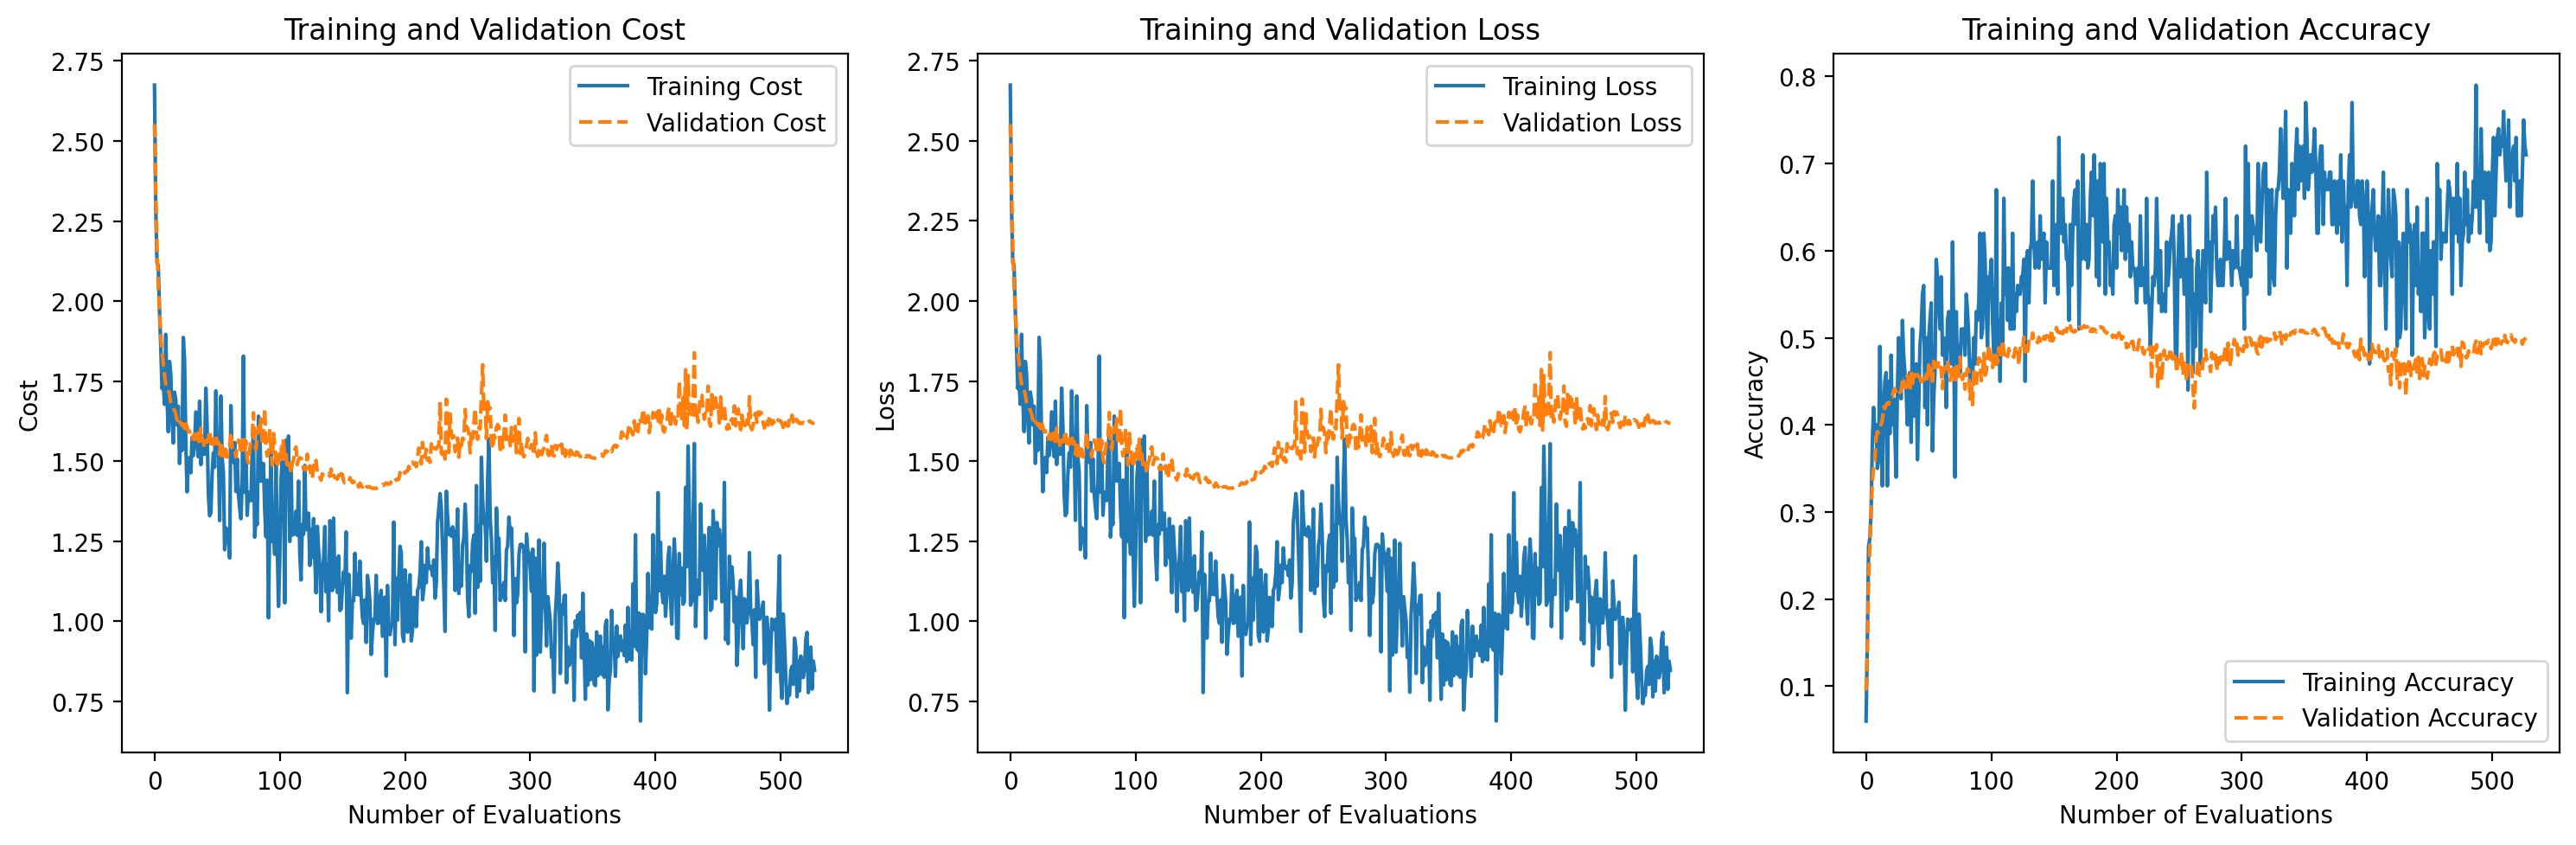

Lambda: 0.000518, Validation Accuracy: 0.5

Starting training with Lambda: 0.001931
Epoch 1/48 | Cost: 1.9816 | Training Accuracy: 0.2951 | Test Accuracy: 0.3722
Epoch 2/48 | Cost: 1.6567 | Training Accuracy: 0.4209 | Test Accuracy: 0.4119
Epoch 3/48 | Cost: 1.5688 | Training Accuracy: 0.4505 | Test Accuracy: 0.4305
Epoch 4/48 | Cost: 1.5084 | Training Accuracy: 0.4700 | Test Accuracy: 0.4355
Epoch 5/48 | Cost: 1.4695 | Training Accuracy: 0.4838 | Test Accuracy: 0.4520
Epoch 6/48 | Cost: 1.4522 | Training Accuracy: 0.4904 | Test Accuracy: 0.4261
Epoch 7/48 | Cost: 1.4436 | Training Accuracy: 0.4952 | Test Accuracy: 0.4212
Epoch 8/48 | Cost: 1.4577 | Training Accuracy: 0.4893 | Test Accuracy: 0.4298
Epoch 9/48 | Cost: 1.4224 | Training Accuracy: 0.5023 | Test Accuracy: 0.4386
Epoch 10/48 | Cost: 1.3463 | Training Accuracy: 0.5297 | Test Accuracy: 0.4178
Epoch 11/48 | Cost: 1.2895 | Training Accuracy: 0.5482 | Test Accuracy: 0.4269
Epoch 12/48 | Cost: 1.2373 | Training Accuracy: 0.5648 |

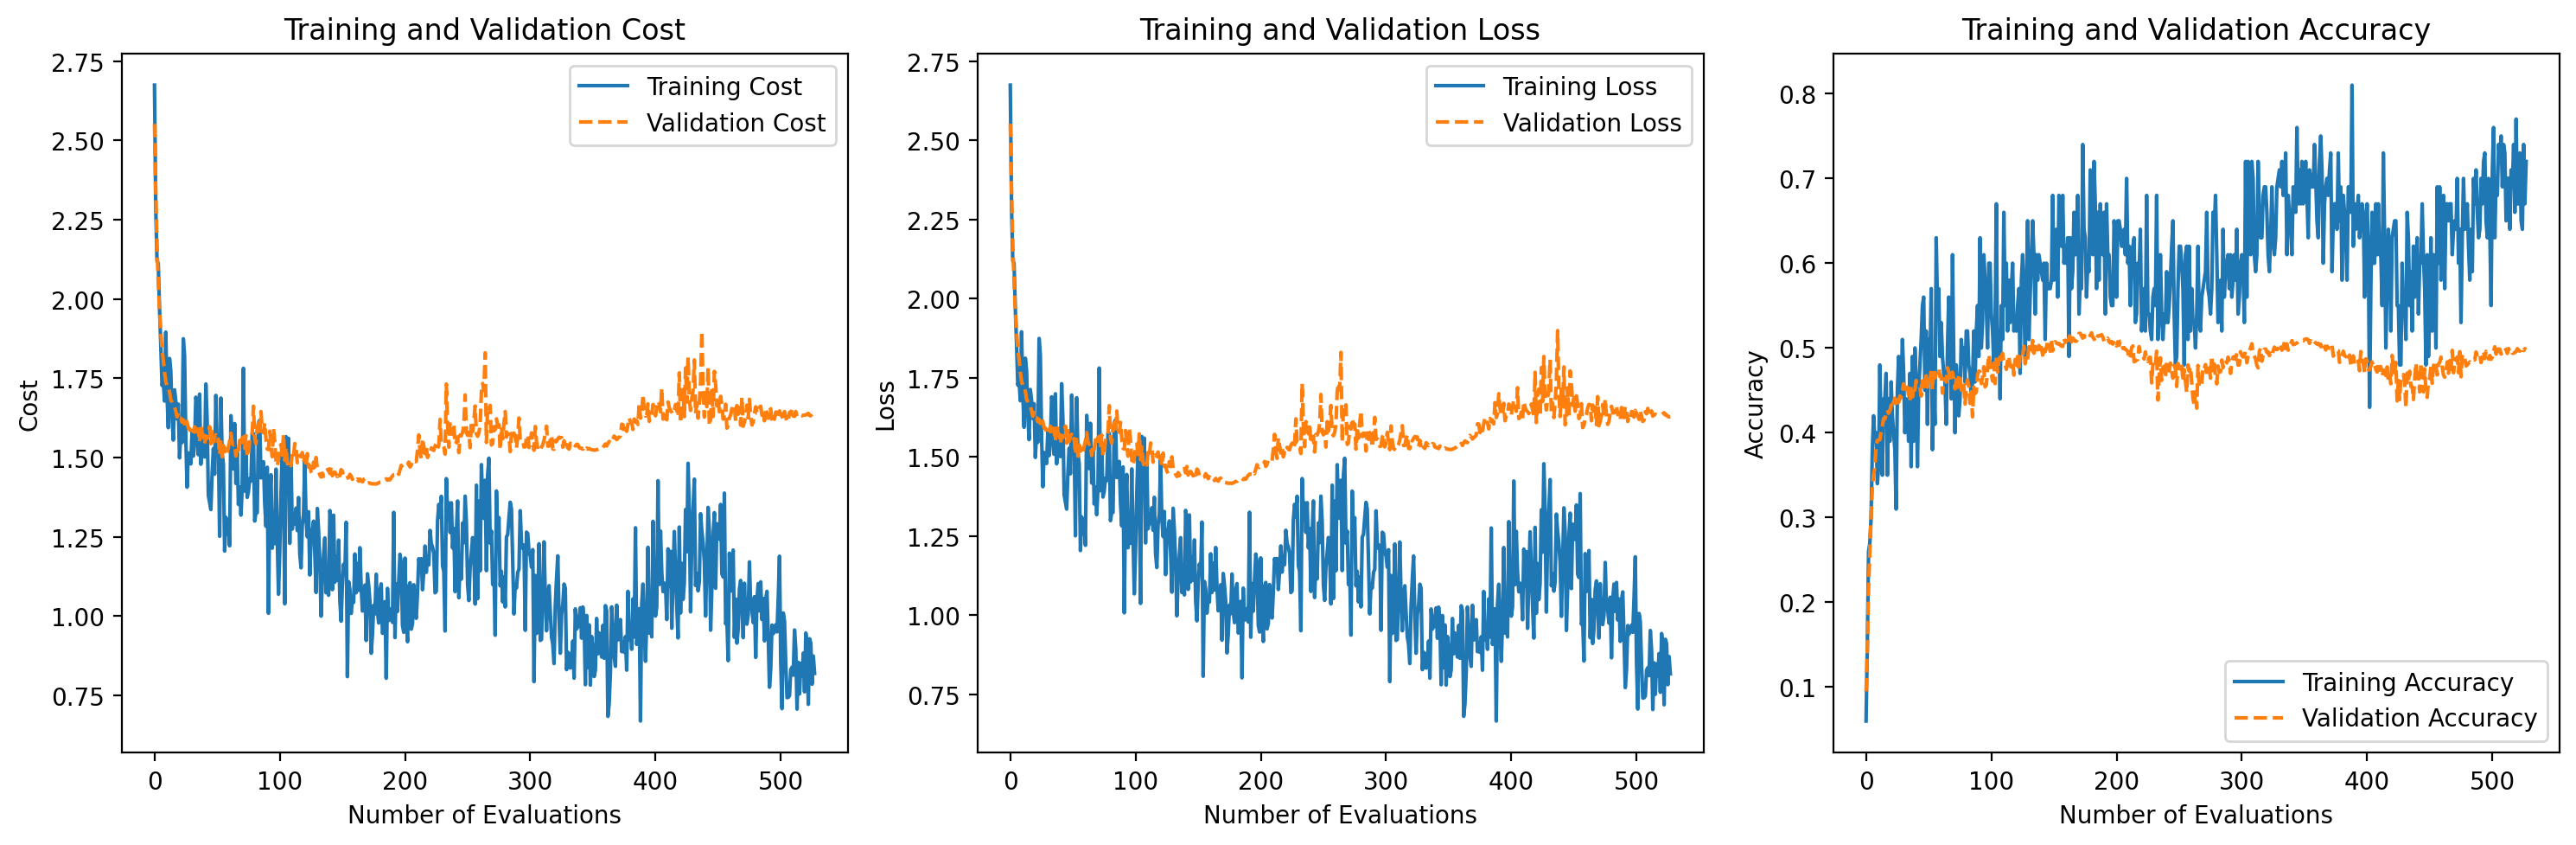

Lambda: 0.001931, Validation Accuracy: 0.4982

Starting training with Lambda: 0.007197
Epoch 1/48 | Cost: 1.9832 | Training Accuracy: 0.2949 | Test Accuracy: 0.3737
Epoch 2/48 | Cost: 1.6587 | Training Accuracy: 0.4208 | Test Accuracy: 0.4127
Epoch 3/48 | Cost: 1.5699 | Training Accuracy: 0.4498 | Test Accuracy: 0.4321
Epoch 4/48 | Cost: 1.5095 | Training Accuracy: 0.4716 | Test Accuracy: 0.4368
Epoch 5/48 | Cost: 1.4696 | Training Accuracy: 0.4851 | Test Accuracy: 0.4491
Epoch 6/48 | Cost: 1.4528 | Training Accuracy: 0.4898 | Test Accuracy: 0.4288
Epoch 7/48 | Cost: 1.4460 | Training Accuracy: 0.4956 | Test Accuracy: 0.4163
Epoch 8/48 | Cost: 1.4581 | Training Accuracy: 0.4905 | Test Accuracy: 0.4272
Epoch 9/48 | Cost: 1.4242 | Training Accuracy: 0.5039 | Test Accuracy: 0.4422
Epoch 10/48 | Cost: 1.3509 | Training Accuracy: 0.5281 | Test Accuracy: 0.4166
Epoch 11/48 | Cost: 1.2915 | Training Accuracy: 0.5470 | Test Accuracy: 0.4294
Epoch 12/48 | Cost: 1.2400 | Training Accuracy: 0.565

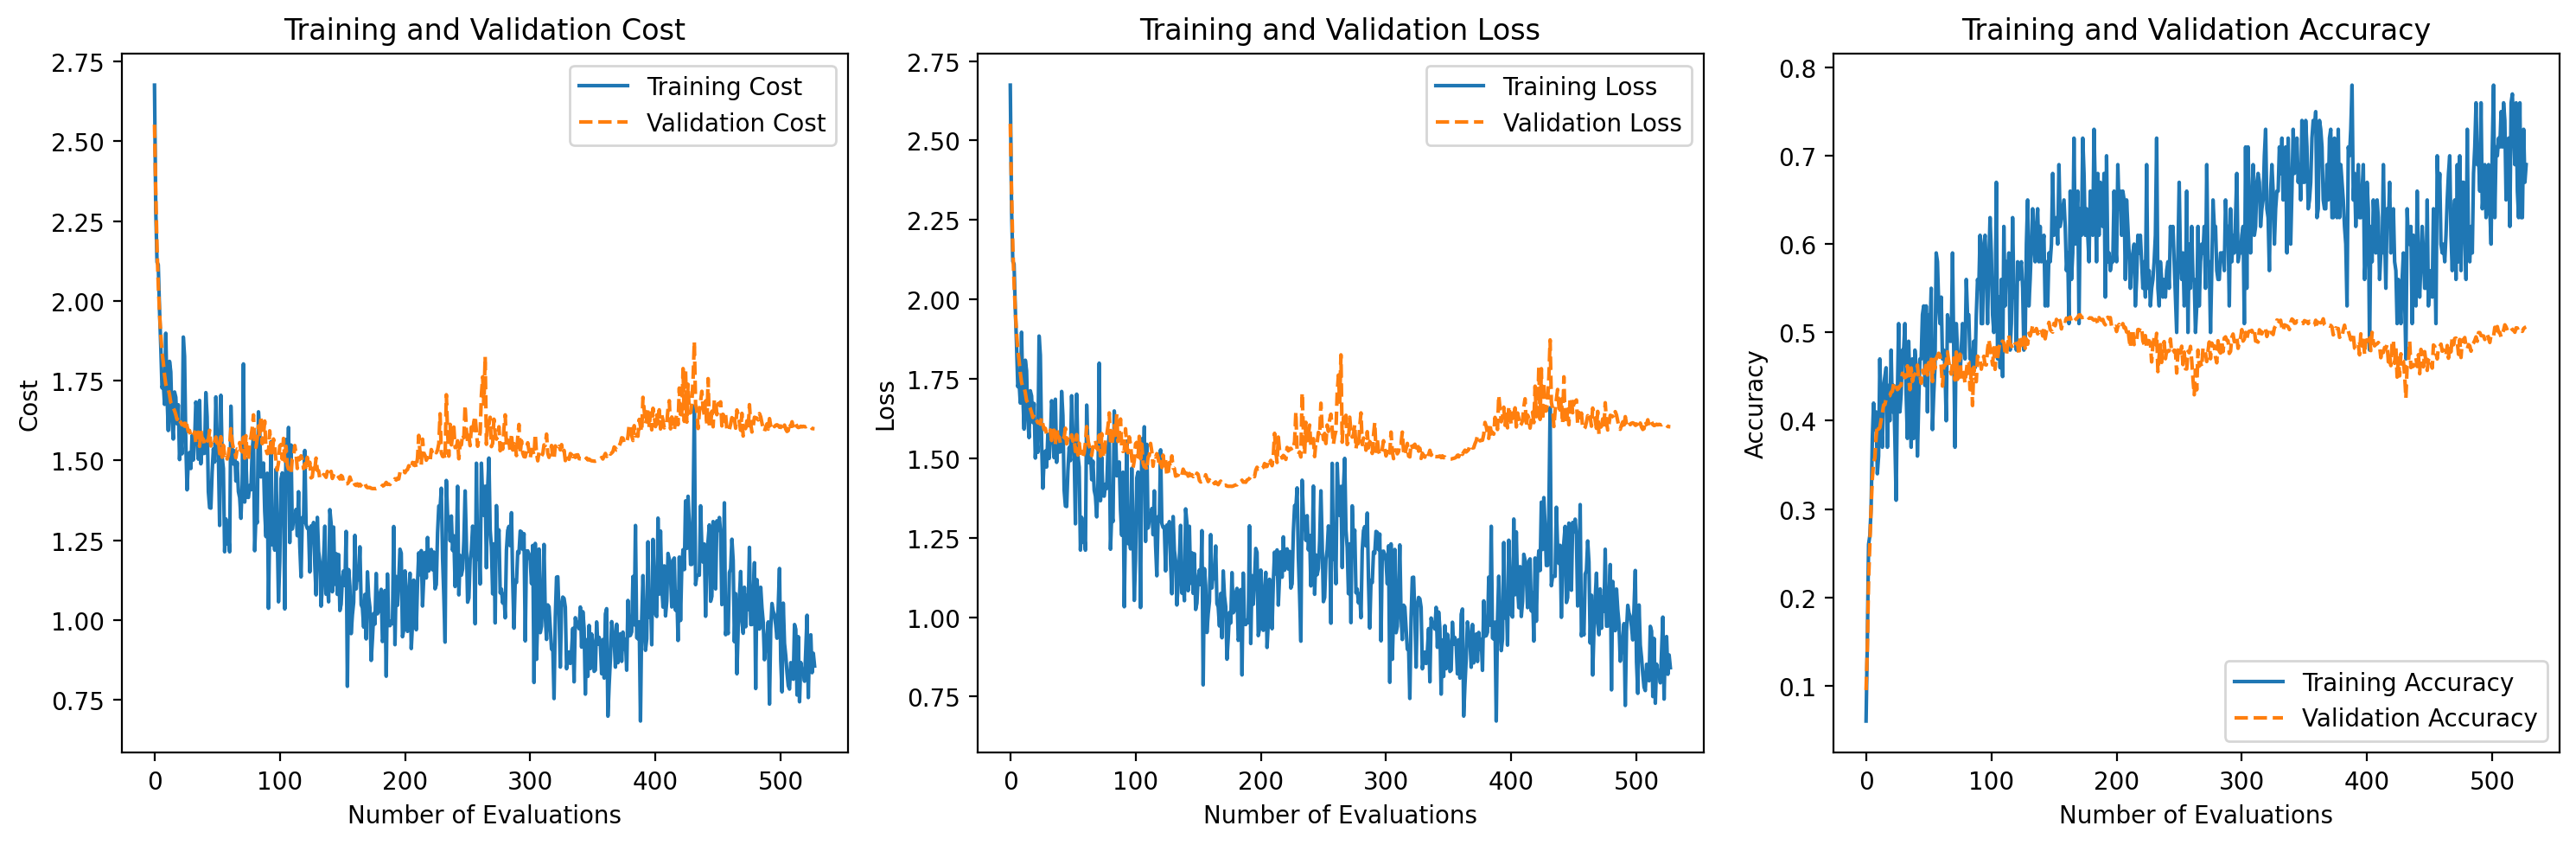

Lambda: 0.007197, Validation Accuracy: 0.5062

Starting training with Lambda: 0.026827
Epoch 1/48 | Cost: 1.9889 | Training Accuracy: 0.2949 | Test Accuracy: 0.3719
Epoch 2/48 | Cost: 1.6642 | Training Accuracy: 0.4205 | Test Accuracy: 0.4141
Epoch 3/48 | Cost: 1.5760 | Training Accuracy: 0.4494 | Test Accuracy: 0.4363
Epoch 4/48 | Cost: 1.5161 | Training Accuracy: 0.4717 | Test Accuracy: 0.4390
Epoch 5/48 | Cost: 1.4788 | Training Accuracy: 0.4849 | Test Accuracy: 0.4520
Epoch 6/48 | Cost: 1.4616 | Training Accuracy: 0.4907 | Test Accuracy: 0.4291
Epoch 7/48 | Cost: 1.4575 | Training Accuracy: 0.4940 | Test Accuracy: 0.4116
Epoch 8/48 | Cost: 1.4683 | Training Accuracy: 0.4875 | Test Accuracy: 0.4184
Epoch 9/48 | Cost: 1.4370 | Training Accuracy: 0.5012 | Test Accuracy: 0.4418
Epoch 10/48 | Cost: 1.3629 | Training Accuracy: 0.5252 | Test Accuracy: 0.4120
Epoch 11/48 | Cost: 1.3058 | Training Accuracy: 0.5479 | Test Accuracy: 0.4285
Epoch 12/48 | Cost: 1.2558 | Training Accuracy: 0.564

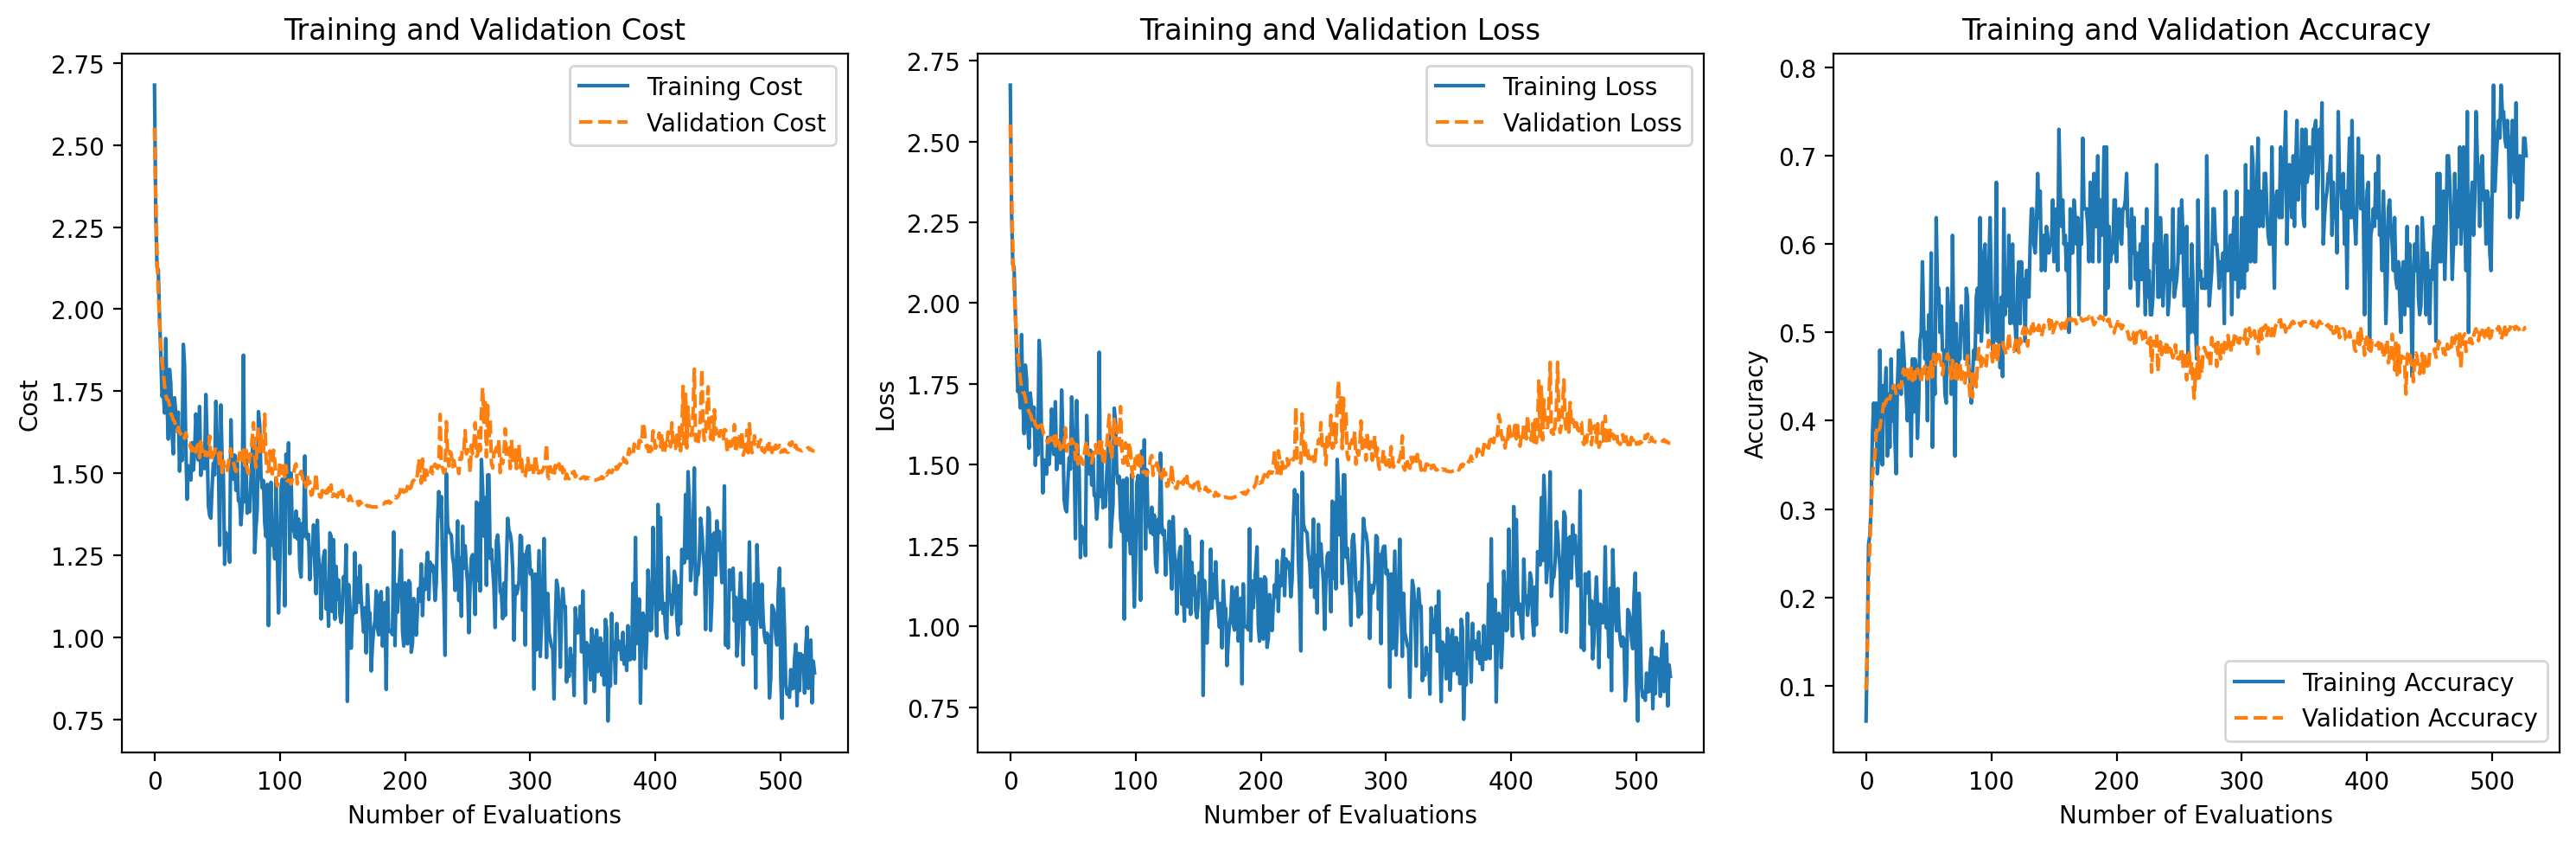

Lambda: 0.026827, Validation Accuracy: 0.5058

Starting training with Lambda: 0.100000
Epoch 1/48 | Cost: 2.0109 | Training Accuracy: 0.2947 | Test Accuracy: 0.3728
Epoch 2/48 | Cost: 1.6873 | Training Accuracy: 0.4190 | Test Accuracy: 0.4125
Epoch 3/48 | Cost: 1.5993 | Training Accuracy: 0.4504 | Test Accuracy: 0.4350
Epoch 4/48 | Cost: 1.5400 | Training Accuracy: 0.4706 | Test Accuracy: 0.4349
Epoch 5/48 | Cost: 1.5040 | Training Accuracy: 0.4853 | Test Accuracy: 0.4543
Epoch 6/48 | Cost: 1.4890 | Training Accuracy: 0.4875 | Test Accuracy: 0.4252
Epoch 7/48 | Cost: 1.4857 | Training Accuracy: 0.4915 | Test Accuracy: 0.4215
Epoch 8/48 | Cost: 1.4997 | Training Accuracy: 0.4873 | Test Accuracy: 0.4150
Epoch 9/48 | Cost: 1.4702 | Training Accuracy: 0.5002 | Test Accuracy: 0.4404
Epoch 10/48 | Cost: 1.4007 | Training Accuracy: 0.5252 | Test Accuracy: 0.4137
Epoch 11/48 | Cost: 1.3475 | Training Accuracy: 0.5450 | Test Accuracy: 0.4382
Epoch 12/48 | Cost: 1.3023 | Training Accuracy: 0.558

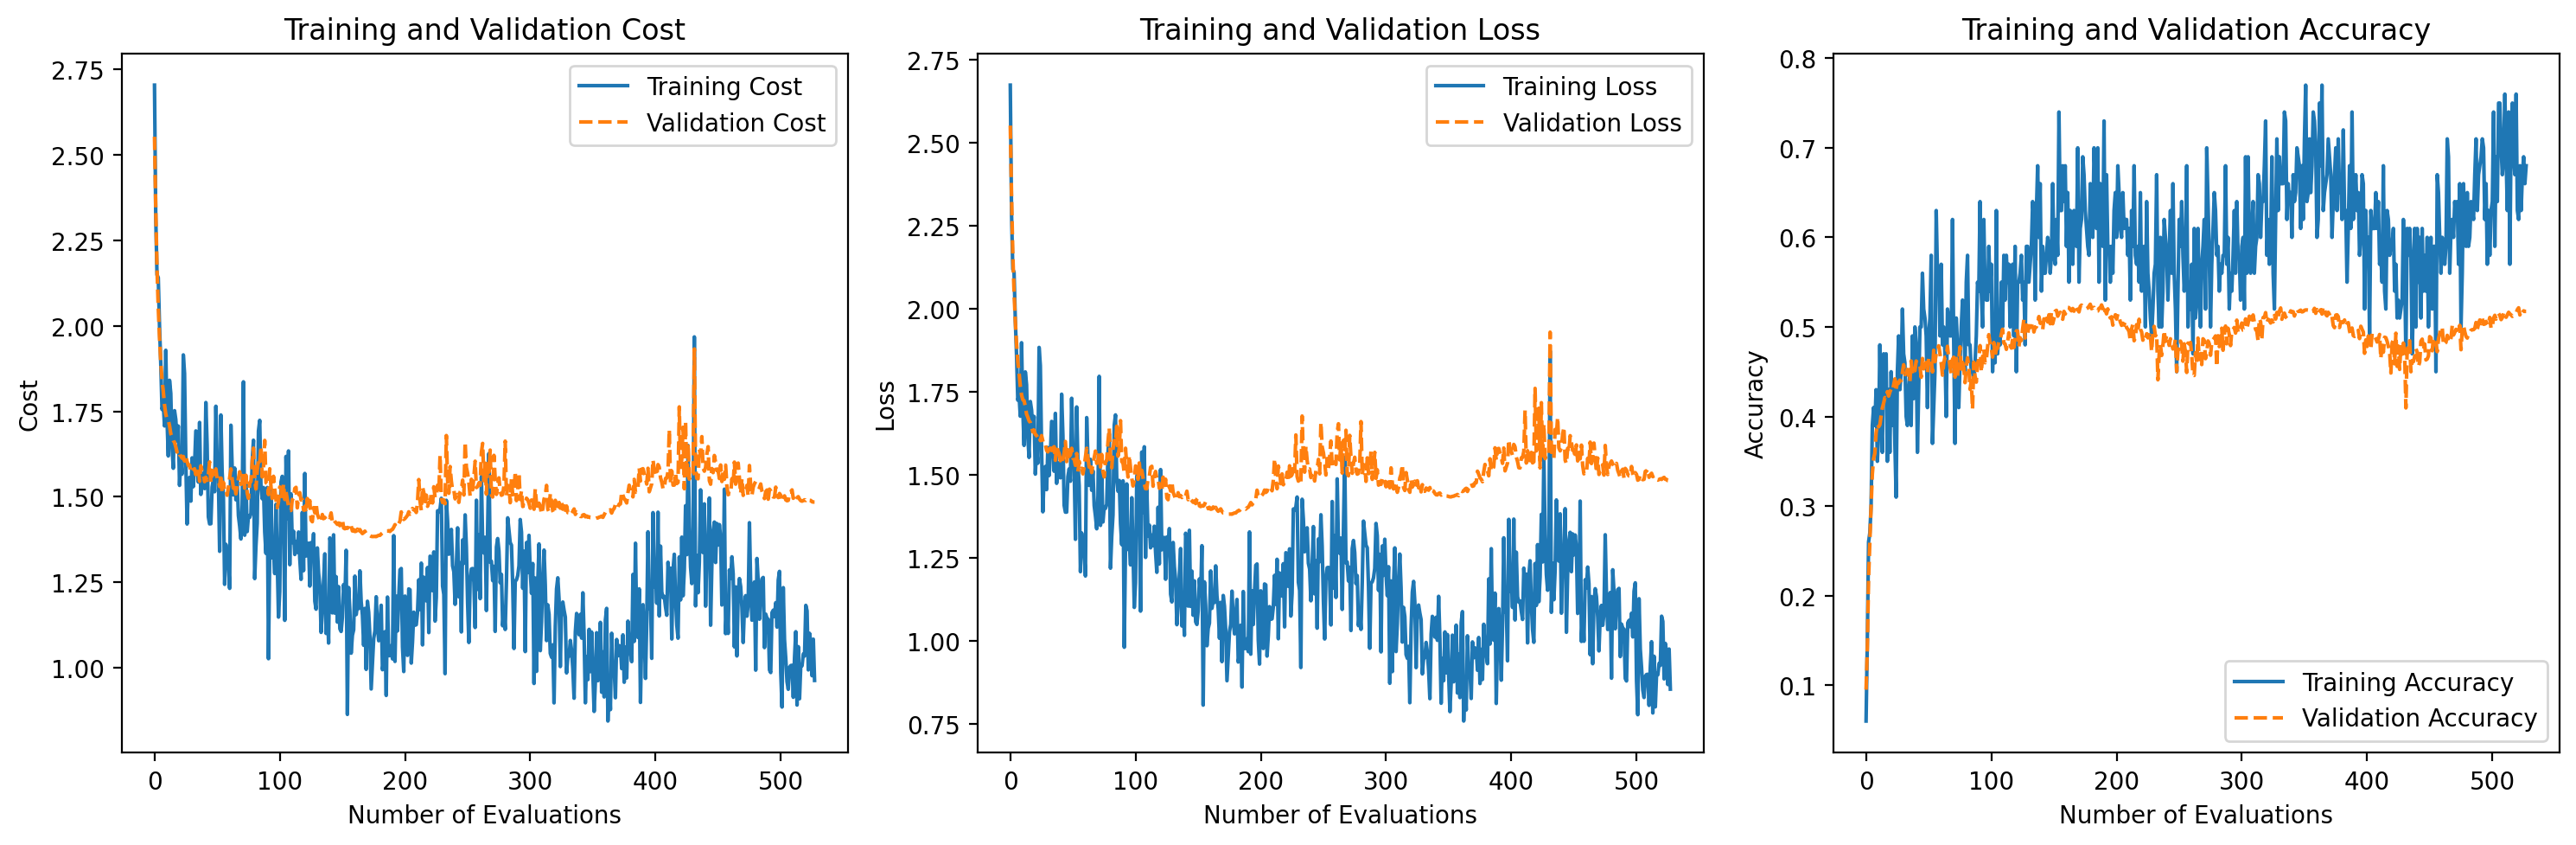

Lambda: 0.100000, Validation Accuracy: 0.5174


In [31]:
epochs = 48 #100 # Set according to training strategy
batch_size = 100
#ns = 900

cycles = 3
num_minibatches = X_train.shape[1] // batch_size
total_iterations = epochs * num_minibatches
iterations_per_cycle = total_iterations / cycles
ns = int(iterations_per_cycle / 2)



#log scale for lambda search
lmin, lmax = -5, -1
lambdas = np.logspace(lmin, lmax, num=8) #CORASE SEARCH: create 3 values between 10^lmin and 10^lmax

results = []
for lambda_ in lambdas:
  params = initialize_parameters(3072, 50, 10) # Fixed!!

  print(f"\nStarting training with Lambda: {lambda_:.6f}")
  params, train_costs, train_losses, train_accuracies, val_costs, val_losses, val_accuracies = train_with_cyclic_lr_val(
      X_train, Y_train, X_val, Y_val, test_X, test_Y, params, epochs, batch_size, ns, lambda_)
  final_accuracy = val_accuracies[-1]
  results.append((lambda_, final_accuracy))
  print(f"Lambda: {lambda_:.6f}, Validation Accuracy: {final_accuracy}")




##Best lambda
We see from the above runs the 3 best lambda leading to the highest accuracy are:
0.1
1e-5
0.000037
```Lambda: 0.01, Validation Accuracy: 0.5174```

Now that we've determined the best value for lambda from our experimentation, we'll train the model with this lambda value using the entire training dataset, and then evaluate its performance on the test dataset to see how well it generalizes.

##Initialize the Parameters
Ensure we start fresh

## Train the model for 1 cycle

Training with lambda = 0.1000
Epoch 1/48 | Cost: 2.1469 | Training Accuracy: 0.2387 | Test Accuracy: 0.3378
Epoch 2/48 | Cost: 1.7898 | Training Accuracy: 0.3857 | Test Accuracy: 0.3917
Epoch 3/48 | Cost: 1.6673 | Training Accuracy: 0.4270 | Test Accuracy: 0.4157
Epoch 4/48 | Cost: 1.5967 | Training Accuracy: 0.4513 | Test Accuracy: 0.4308
Epoch 5/48 | Cost: 1.5455 | Training Accuracy: 0.4710 | Test Accuracy: 0.4457
Epoch 6/48 | Cost: 1.5042 | Training Accuracy: 0.4863 | Test Accuracy: 0.4420
Epoch 7/48 | Cost: 1.4690 | Training Accuracy: 0.4970 | Test Accuracy: 0.4537
Epoch 8/48 | Cost: 1.4424 | Training Accuracy: 0.5046 | Test Accuracy: 0.4521
Epoch 9/48 | Cost: 1.4201 | Training Accuracy: 0.5134 | Test Accuracy: 0.4559
Epoch 10/48 | Cost: 1.4010 | Training Accuracy: 0.5218 | Test Accuracy: 0.4567
Epoch 11/48 | Cost: 1.3860 | Training Accuracy: 0.5283 | Test Accuracy: 0.4290
Epoch 12/48 | Cost: 1.3751 | Training Accuracy: 0.5304 | Test Accuracy: 0.4492
Epoch 13/48 | Cost: 1.3722 | Tr

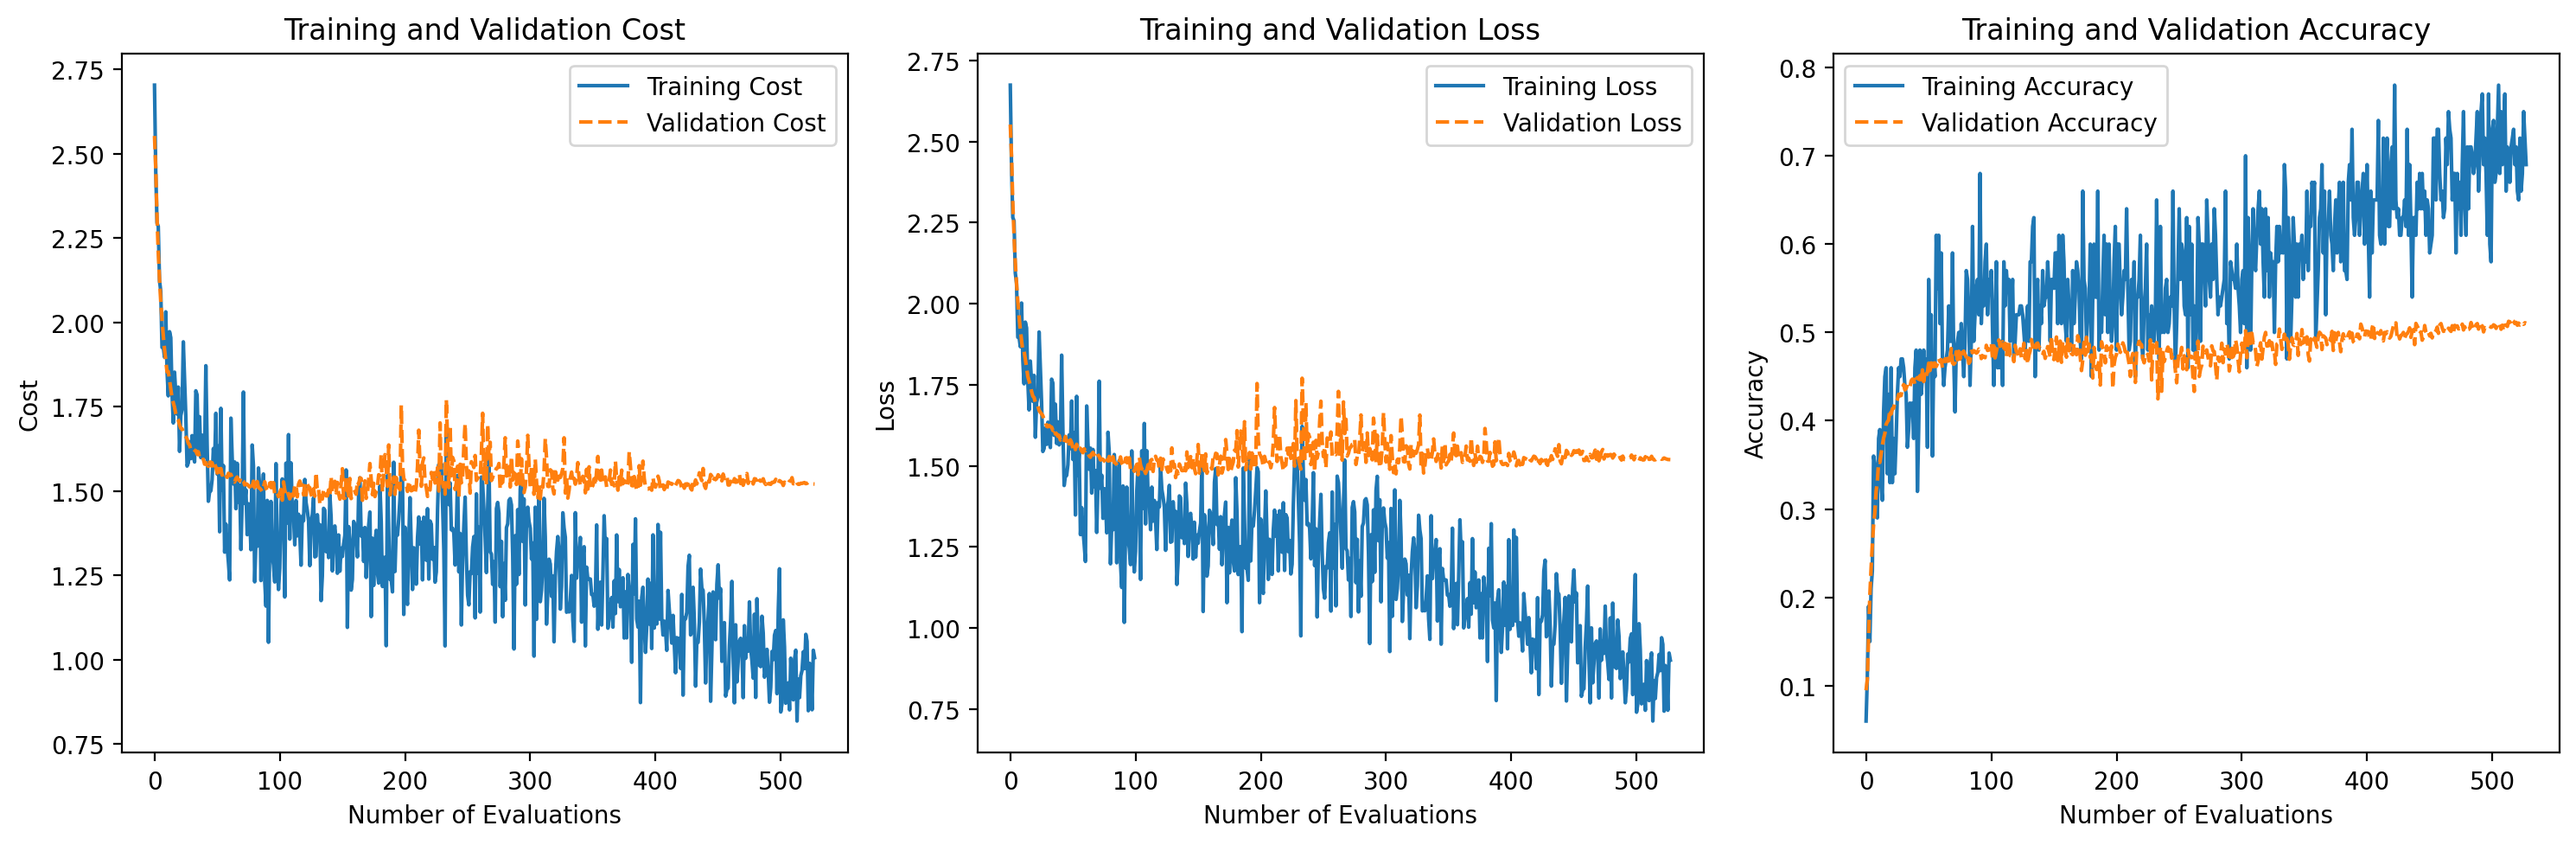

Lambda: 0.100000, Train Accuracy: [0.06, 0.11, 0.19, 0.15, 0.21, 0.23, 0.36, 0.35, 0.32, 0.29, 0.38, 0.39, 0.33, 0.31, 0.41, 0.45, 0.46, 0.34, 0.43, 0.33, 0.46, 0.33, 0.38, 0.34, 0.38, 0.43, 0.46, 0.45, 0.47, 0.47, 0.46, 0.44, 0.43, 0.37, 0.39, 0.42, 0.41, 0.42, 0.38, 0.46, 0.48, 0.32, 0.39, 0.48, 0.43, 0.45, 0.48, 0.45, 0.47, 0.37, 0.56, 0.48, 0.52, 0.36, 0.47, 0.45, 0.61, 0.55, 0.61, 0.51, 0.59, 0.47, 0.44, 0.46, 0.47, 0.48, 0.53, 0.49, 0.49, 0.59, 0.47, 0.41, 0.48, 0.49, 0.5, 0.47, 0.51, 0.48, 0.45, 0.49, 0.57, 0.56, 0.52, 0.44, 0.49, 0.62, 0.49, 0.52, 0.55, 0.56, 0.52, 0.68, 0.51, 0.55, 0.53, 0.58, 0.6, 0.52, 0.56, 0.55, 0.57, 0.5, 0.44, 0.51, 0.58, 0.46, 0.48, 0.46, 0.49, 0.44, 0.58, 0.53, 0.57, 0.55, 0.56, 0.49, 0.53, 0.56, 0.47, 0.49, 0.52, 0.52, 0.52, 0.53, 0.53, 0.52, 0.5, 0.48, 0.51, 0.53, 0.49, 0.58, 0.58, 0.62, 0.63, 0.45, 0.54, 0.56, 0.48, 0.53, 0.51, 0.57, 0.53, 0.54, 0.54, 0.58, 0.55, 0.49, 0.56, 0.56, 0.55, 0.59, 0.59, 0.51, 0.61, 0.54, 0.51, 0.61, 0.58, 0.51, 0.49, 0.5

In [37]:
input_dim = 3072
hidden_dim = 50
output_dim = 10
epochs = 48 #100 # Set according to training strategy
batch_size = 100
#ns = 900

cycles = 1
num_minibatches = X_train.shape[1] // batch_size
total_iterations = epochs * num_minibatches
iterations_per_cycle = total_iterations / cycles
ns = int(iterations_per_cycle / 2)

lambda_ =  0.1 #0.01 #0.007197  # The best lambda determined from previous experiments

params = initialize_parameters(input_dim, hidden_dim, output_dim)

# Train the model with the selected lambda
print(f"Training with lambda = {lambda_:.4f}")
#params, train_costs, train_losses, train_accuracies, lrs = train_with_cyclic_lr(
#        X_train, Y_train, params, epochs, batch_size, ns, lambda_)

params, train_costs, train_losses, train_accuracies, val_costs, val_losses, val_accuracies = train_with_cyclic_lr_val(
      X_train, Y_train, X_val, Y_val, test_X, test_Y, params, epochs, batch_size, ns, lambda_)
#final_accuracy = train_accuracies[-1]
#results.append((lambda_, final_accuracy))
print(f"Lambda: {lambda_:.6f}, Train Accuracy: {train_accuracies}, Validation Accuracy: {val_accuracies}")


In [38]:
input_dim = 3072
hidden_dim = 50
output_dim = 10
epochs = 48 #100 # Set according to training strategy
batch_size = 100
#ns = 900

cycles = 3
num_minibatches = X_train.shape[1] // batch_size
total_iterations = epochs * num_minibatches
iterations_per_cycle = total_iterations / cycles
ns = int(iterations_per_cycle / 2)

lambda_ = 0.1 #0.007197  # The best lambda determined from previous experiments

params = initialize_parameters(input_dim, hidden_dim, output_dim)


##Train the model for 3 Cycles



Training with lambda = 0.1000
Epoch 1/48 | Cost: 2.0109 | Training Accuracy: 0.2947 | Test Accuracy: 0.3728
Epoch 2/48 | Cost: 1.6873 | Training Accuracy: 0.4190 | Test Accuracy: 0.4125
Epoch 3/48 | Cost: 1.5993 | Training Accuracy: 0.4504 | Test Accuracy: 0.4350
Epoch 4/48 | Cost: 1.5400 | Training Accuracy: 0.4706 | Test Accuracy: 0.4349
Epoch 5/48 | Cost: 1.5040 | Training Accuracy: 0.4853 | Test Accuracy: 0.4543
Epoch 6/48 | Cost: 1.4890 | Training Accuracy: 0.4875 | Test Accuracy: 0.4252
Epoch 7/48 | Cost: 1.4857 | Training Accuracy: 0.4915 | Test Accuracy: 0.4215
Epoch 8/48 | Cost: 1.4997 | Training Accuracy: 0.4873 | Test Accuracy: 0.4150
Epoch 9/48 | Cost: 1.4702 | Training Accuracy: 0.5002 | Test Accuracy: 0.4404
Epoch 10/48 | Cost: 1.4007 | Training Accuracy: 0.5252 | Test Accuracy: 0.4137
Epoch 11/48 | Cost: 1.3475 | Training Accuracy: 0.5450 | Test Accuracy: 0.4382
Epoch 12/48 | Cost: 1.3023 | Training Accuracy: 0.5588 | Test Accuracy: 0.4340
Epoch 13/48 | Cost: 1.2555 | Tr

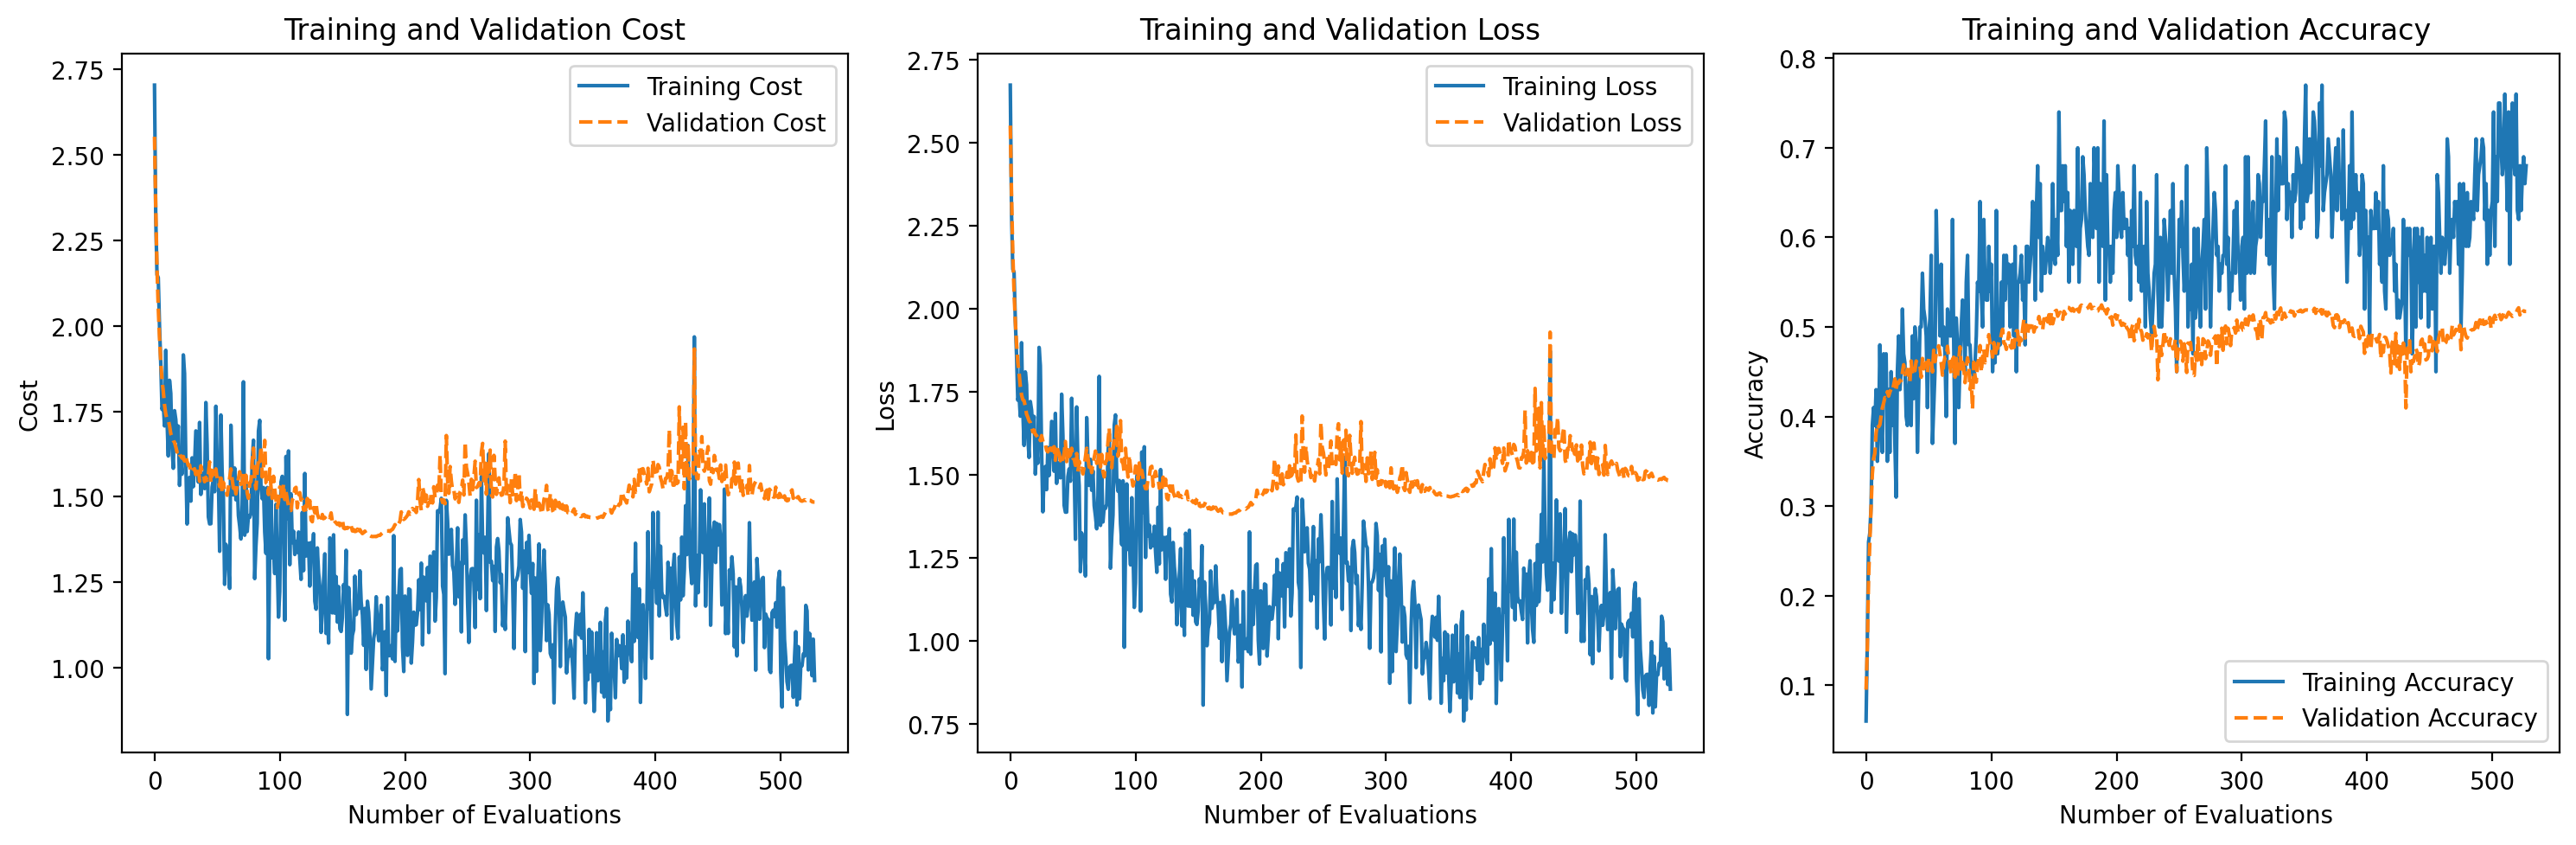

Lambda: 0.100000, Train Accuracy: [0.06, 0.15, 0.26, 0.27, 0.3, 0.39, 0.41, 0.39, 0.43, 0.35, 0.38, 0.48, 0.4, 0.36, 0.47, 0.46, 0.47, 0.35, 0.43, 0.36, 0.45, 0.39, 0.44, 0.37, 0.31, 0.45, 0.49, 0.43, 0.45, 0.52, 0.47, 0.46, 0.4, 0.39, 0.43, 0.45, 0.39, 0.49, 0.42, 0.5, 0.48, 0.36, 0.43, 0.5, 0.5, 0.56, 0.52, 0.51, 0.49, 0.41, 0.49, 0.51, 0.58, 0.37, 0.41, 0.45, 0.63, 0.56, 0.56, 0.49, 0.57, 0.48, 0.5, 0.47, 0.4, 0.52, 0.51, 0.49, 0.49, 0.62, 0.48, 0.37, 0.51, 0.48, 0.41, 0.46, 0.5, 0.53, 0.52, 0.45, 0.55, 0.58, 0.48, 0.48, 0.45, 0.45, 0.44, 0.46, 0.49, 0.55, 0.54, 0.64, 0.54, 0.5, 0.62, 0.54, 0.53, 0.53, 0.59, 0.54, 0.57, 0.45, 0.5, 0.46, 0.63, 0.47, 0.49, 0.48, 0.55, 0.5, 0.58, 0.53, 0.58, 0.55, 0.57, 0.5, 0.55, 0.57, 0.49, 0.59, 0.45, 0.55, 0.55, 0.56, 0.58, 0.53, 0.55, 0.48, 0.59, 0.59, 0.55, 0.57, 0.59, 0.64, 0.62, 0.53, 0.63, 0.68, 0.6, 0.66, 0.54, 0.59, 0.56, 0.56, 0.58, 0.6, 0.59, 0.56, 0.58, 0.66, 0.58, 0.57, 0.62, 0.58, 0.74, 0.63, 0.63, 0.68, 0.64, 0.68, 0.59, 0.65, 0.55, 0.

In [39]:
# Train the model with the selected lambda
print(f"Training with lambda = {lambda_:.4f}")
#params, train_costs, train_losses, train_accuracies, lrs = train_with_cyclic_lr(
#        X_train, Y_train, params, epochs, batch_size, ns, lambda_)

params, train_costs, train_losses, train_accuracies, val_costs, val_losses, val_accuracies = train_with_cyclic_lr_val(
      X_train, Y_train, X_val, Y_val, test_X, test_Y, params, epochs, batch_size, ns, lambda_)
#final_accuracy = train_accuracies[-1]
#results.append((lambda_, final_accuracy))
print(f"Lambda: {lambda_:.6f}, Train Accuracy: {train_accuracies}, Validation Accuracy: {val_accuracies}")

In [40]:
X_train.shape

(3072, 45000)

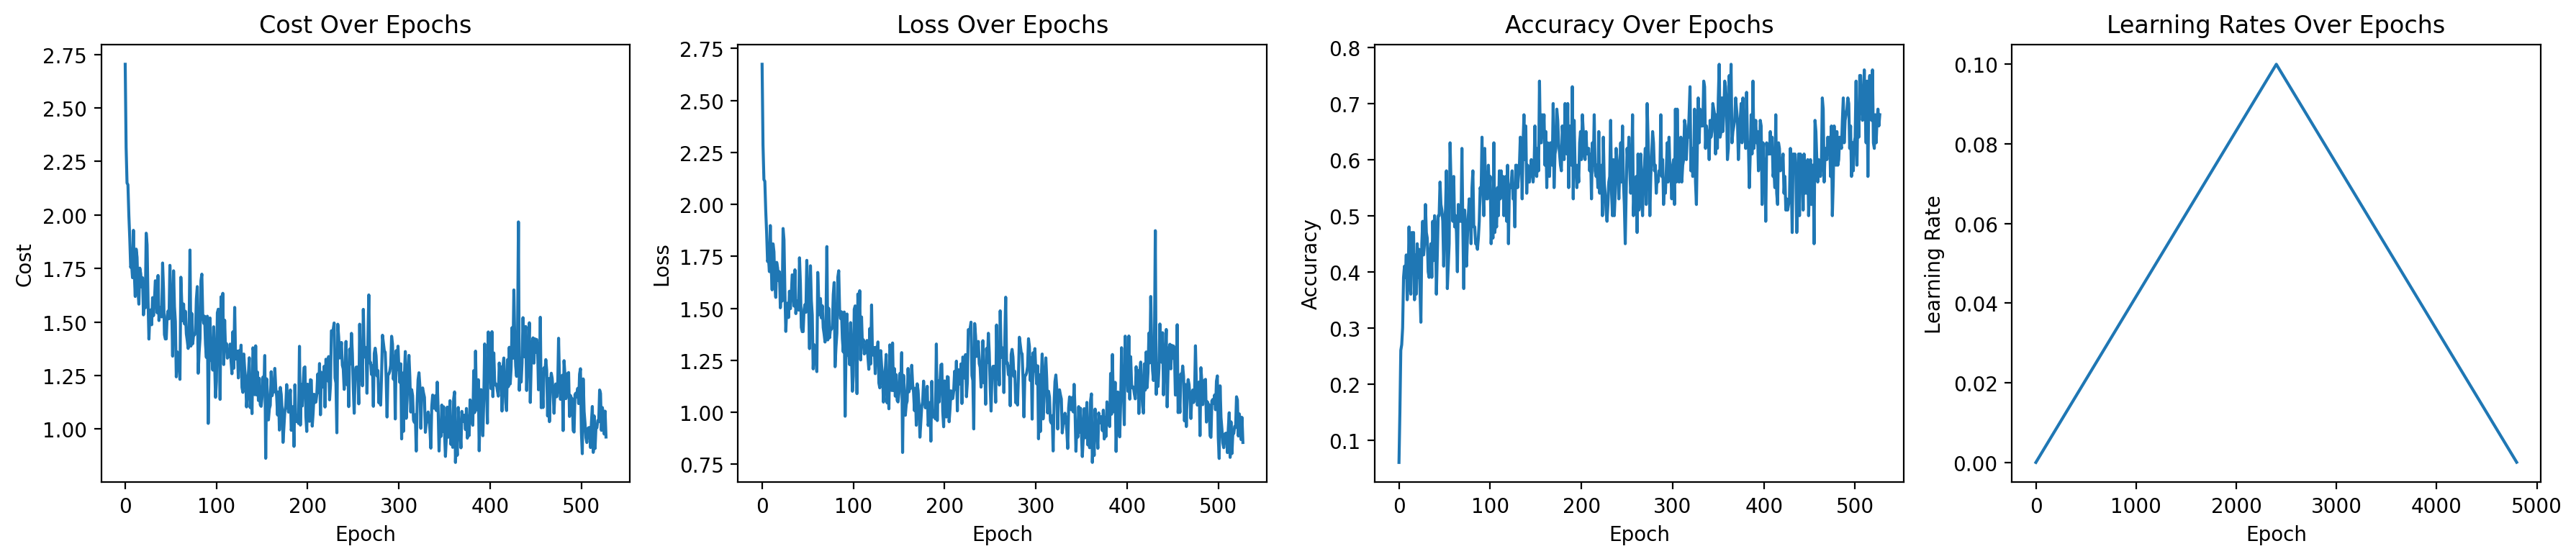

In [41]:
import matplotlib.pyplot as plt
#train_costs, train_losses, train_accuracies, lrs
plt.figure(figsize=(18, 4))

plt.subplot(1, 4, 1)
plt.plot(train_costs)
plt.title('Cost Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Cost')

plt.subplot(1, 4, 2)
plt.plot(train_losses)
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 4, 3)
plt.plot(train_accuracies)
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 4, 4)
plt.plot(lrs)
plt.title('Learning Rates Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')

plt.tight_layout()
# Save the current figure into the PDF before showing it
plt.show()
plt.close()  # Close the figure to free up memory

##Evaluate on the test dataset


In [42]:
# Evaluate on the test dataset
P_test, _ = forward_pass(test_X, params)
test_accuracy = compute_accuracy(P_test, test_Y)

print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.4131


In [43]:
test_X.shape[1]

10000

In [44]:
test_Y.shape

(10, 10000)


Starting training with Lambda: 0.000010
Epoch 1/48 | Cost: 2.1173 | Training Accuracy: 0.2387 | Test Accuracy: 0.3384
Epoch 2/48 | Cost: 1.7599 | Training Accuracy: 0.3855 | Test Accuracy: 0.3925
Epoch 3/48 | Cost: 1.6363 | Training Accuracy: 0.4278 | Test Accuracy: 0.4155
Epoch 4/48 | Cost: 1.5654 | Training Accuracy: 0.4515 | Test Accuracy: 0.4330
Epoch 5/48 | Cost: 1.5133 | Training Accuracy: 0.4697 | Test Accuracy: 0.4486
Epoch 6/48 | Cost: 1.4711 | Training Accuracy: 0.4857 | Test Accuracy: 0.4386
Epoch 7/48 | Cost: 1.4349 | Training Accuracy: 0.4983 | Test Accuracy: 0.4510
Epoch 8/48 | Cost: 1.4065 | Training Accuracy: 0.5056 | Test Accuracy: 0.4586
Epoch 9/48 | Cost: 1.3810 | Training Accuracy: 0.5160 | Test Accuracy: 0.4565
Epoch 10/48 | Cost: 1.3606 | Training Accuracy: 0.5243 | Test Accuracy: 0.4545
Epoch 11/48 | Cost: 1.3416 | Training Accuracy: 0.5283 | Test Accuracy: 0.4320
Epoch 12/48 | Cost: 1.3280 | Training Accuracy: 0.5337 | Test Accuracy: 0.4440
Epoch 13/48 | Cost: 

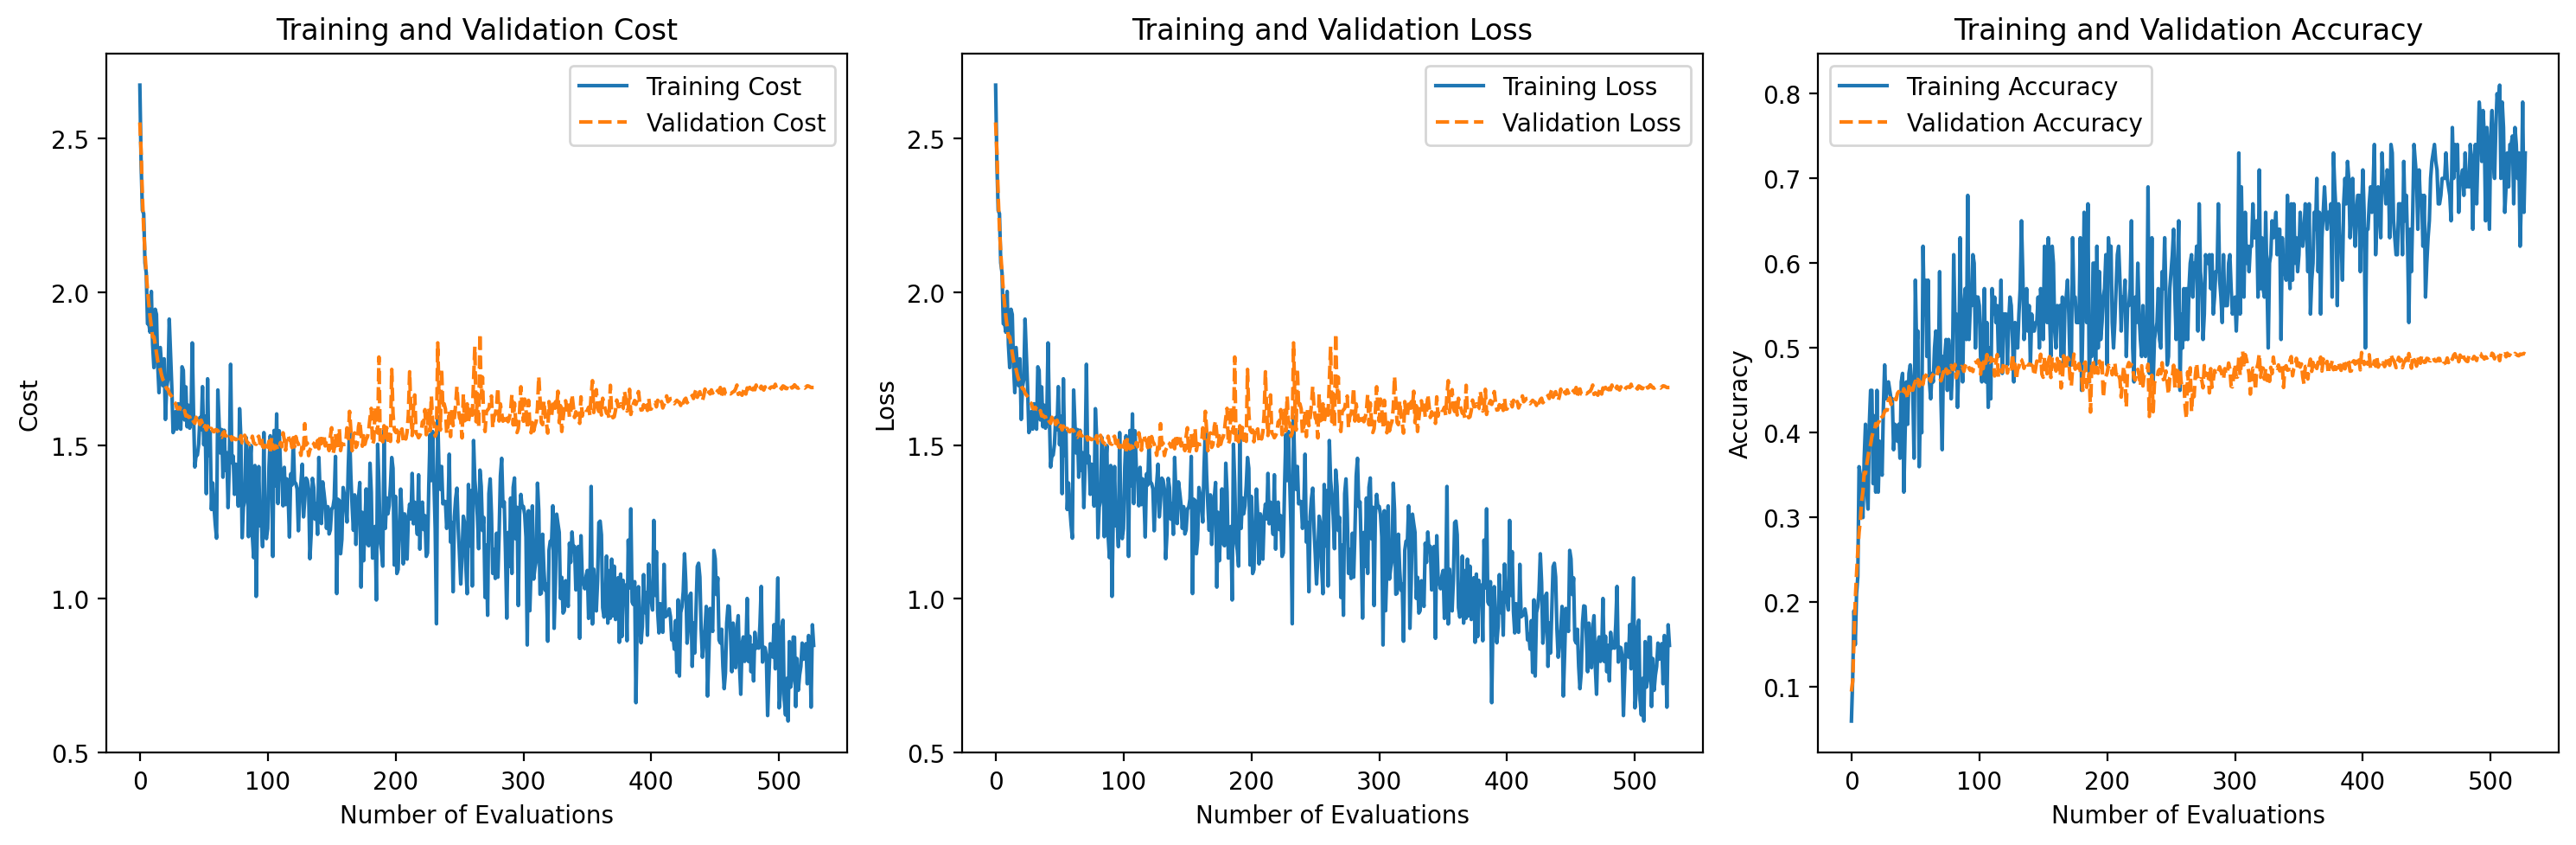

Lambda: 0.000010, Validation Accuracy: 0.4928

Starting training with Lambda: 0.000037
Epoch 1/48 | Cost: 2.1173 | Training Accuracy: 0.2387 | Test Accuracy: 0.3384
Epoch 2/48 | Cost: 1.7599 | Training Accuracy: 0.3855 | Test Accuracy: 0.3925
Epoch 3/48 | Cost: 1.6363 | Training Accuracy: 0.4278 | Test Accuracy: 0.4155
Epoch 4/48 | Cost: 1.5654 | Training Accuracy: 0.4516 | Test Accuracy: 0.4311
Epoch 5/48 | Cost: 1.5133 | Training Accuracy: 0.4708 | Test Accuracy: 0.4480
Epoch 6/48 | Cost: 1.4715 | Training Accuracy: 0.4857 | Test Accuracy: 0.4374
Epoch 7/48 | Cost: 1.4341 | Training Accuracy: 0.4976 | Test Accuracy: 0.4528
Epoch 8/48 | Cost: 1.4063 | Training Accuracy: 0.5061 | Test Accuracy: 0.4573
Epoch 9/48 | Cost: 1.3819 | Training Accuracy: 0.5165 | Test Accuracy: 0.4534
Epoch 10/48 | Cost: 1.3598 | Training Accuracy: 0.5238 | Test Accuracy: 0.4564
Epoch 11/48 | Cost: 1.3410 | Training Accuracy: 0.5293 | Test Accuracy: 0.4355
Epoch 12/48 | Cost: 1.3289 | Training Accuracy: 0.534

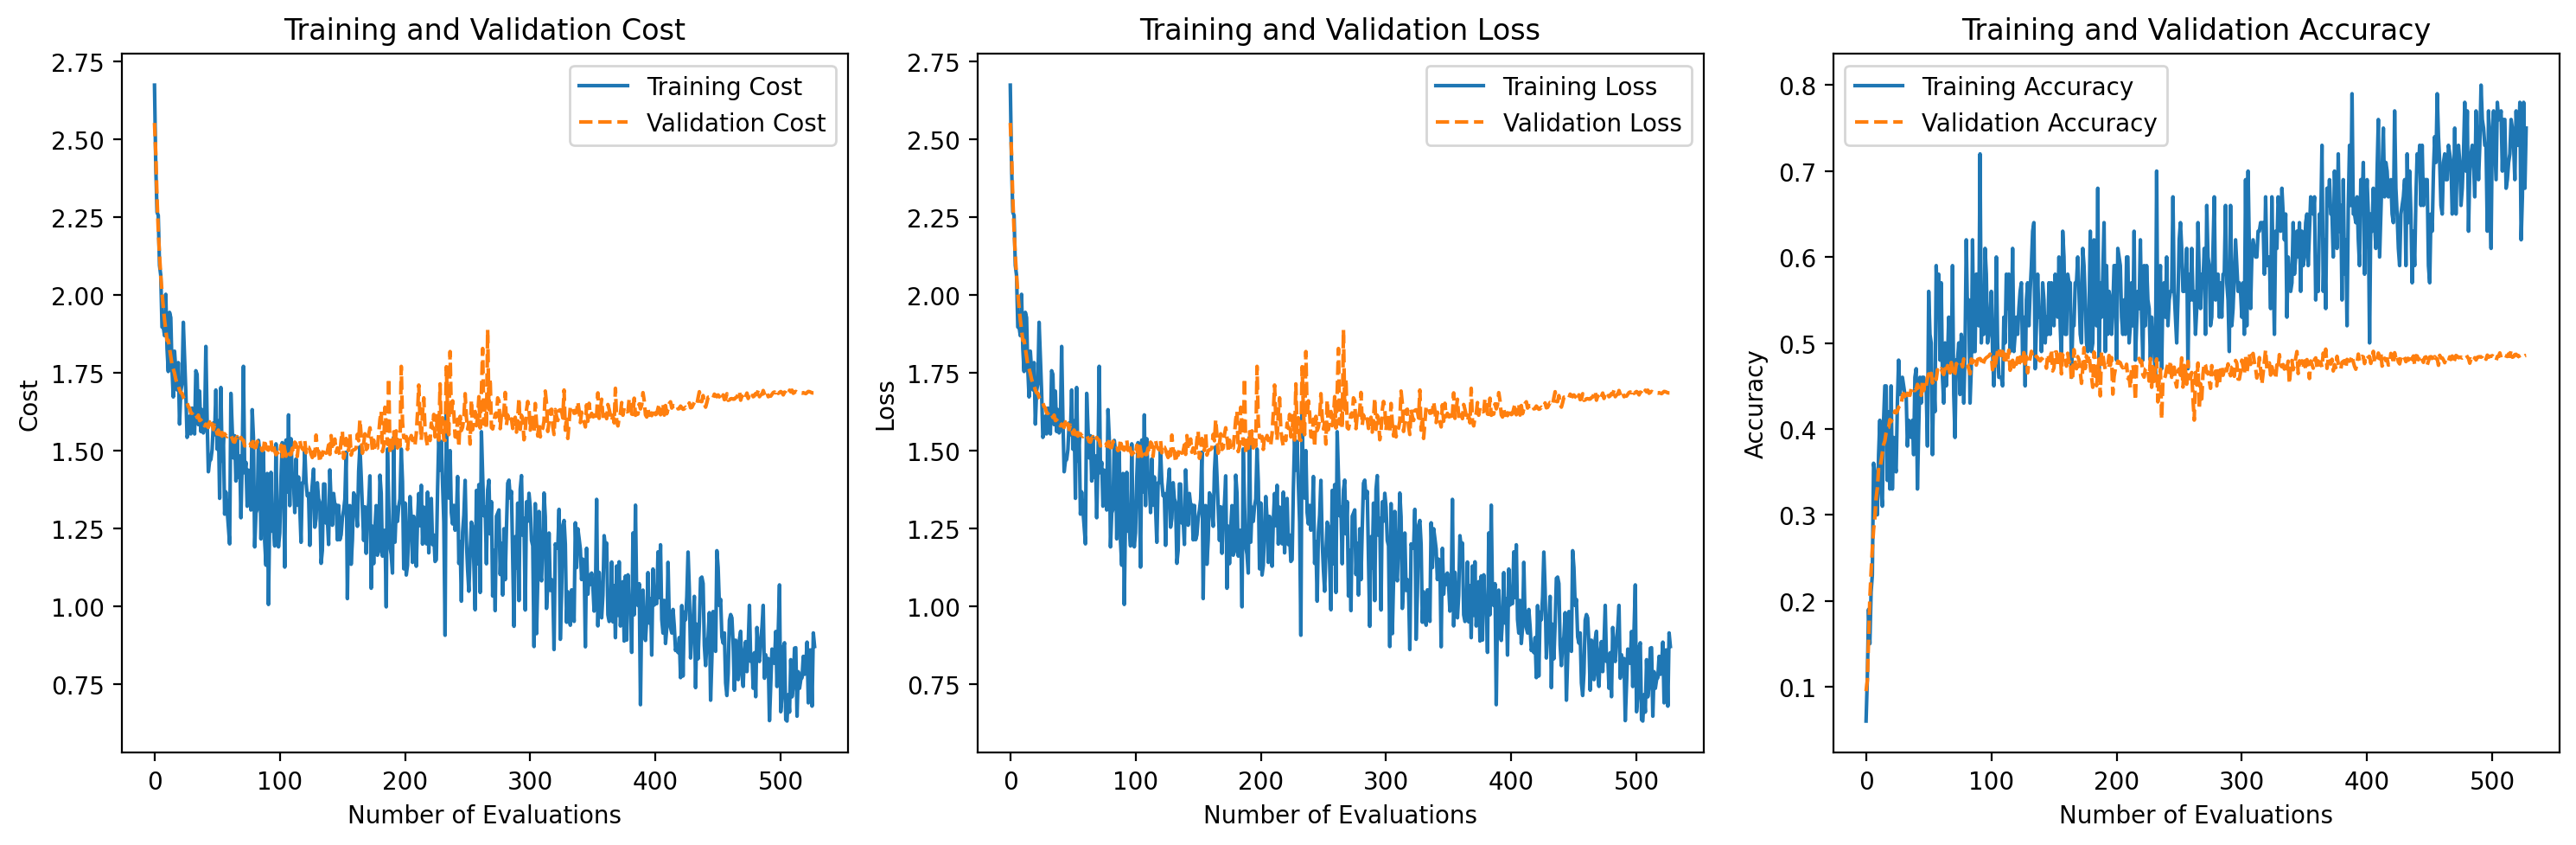

Lambda: 0.000037, Validation Accuracy: 0.4854

Starting training with Lambda: 0.100000
Epoch 1/48 | Cost: 2.1469 | Training Accuracy: 0.2387 | Test Accuracy: 0.3378
Epoch 2/48 | Cost: 1.7898 | Training Accuracy: 0.3857 | Test Accuracy: 0.3917
Epoch 3/48 | Cost: 1.6673 | Training Accuracy: 0.4270 | Test Accuracy: 0.4157
Epoch 4/48 | Cost: 1.5967 | Training Accuracy: 0.4513 | Test Accuracy: 0.4308
Epoch 5/48 | Cost: 1.5455 | Training Accuracy: 0.4710 | Test Accuracy: 0.4457
Epoch 6/48 | Cost: 1.5042 | Training Accuracy: 0.4863 | Test Accuracy: 0.4420
Epoch 7/48 | Cost: 1.4690 | Training Accuracy: 0.4970 | Test Accuracy: 0.4537
Epoch 8/48 | Cost: 1.4424 | Training Accuracy: 0.5046 | Test Accuracy: 0.4521
Epoch 9/48 | Cost: 1.4201 | Training Accuracy: 0.5134 | Test Accuracy: 0.4559
Epoch 10/48 | Cost: 1.4010 | Training Accuracy: 0.5218 | Test Accuracy: 0.4567
Epoch 11/48 | Cost: 1.3860 | Training Accuracy: 0.5283 | Test Accuracy: 0.4290
Epoch 12/48 | Cost: 1.3751 | Training Accuracy: 0.530

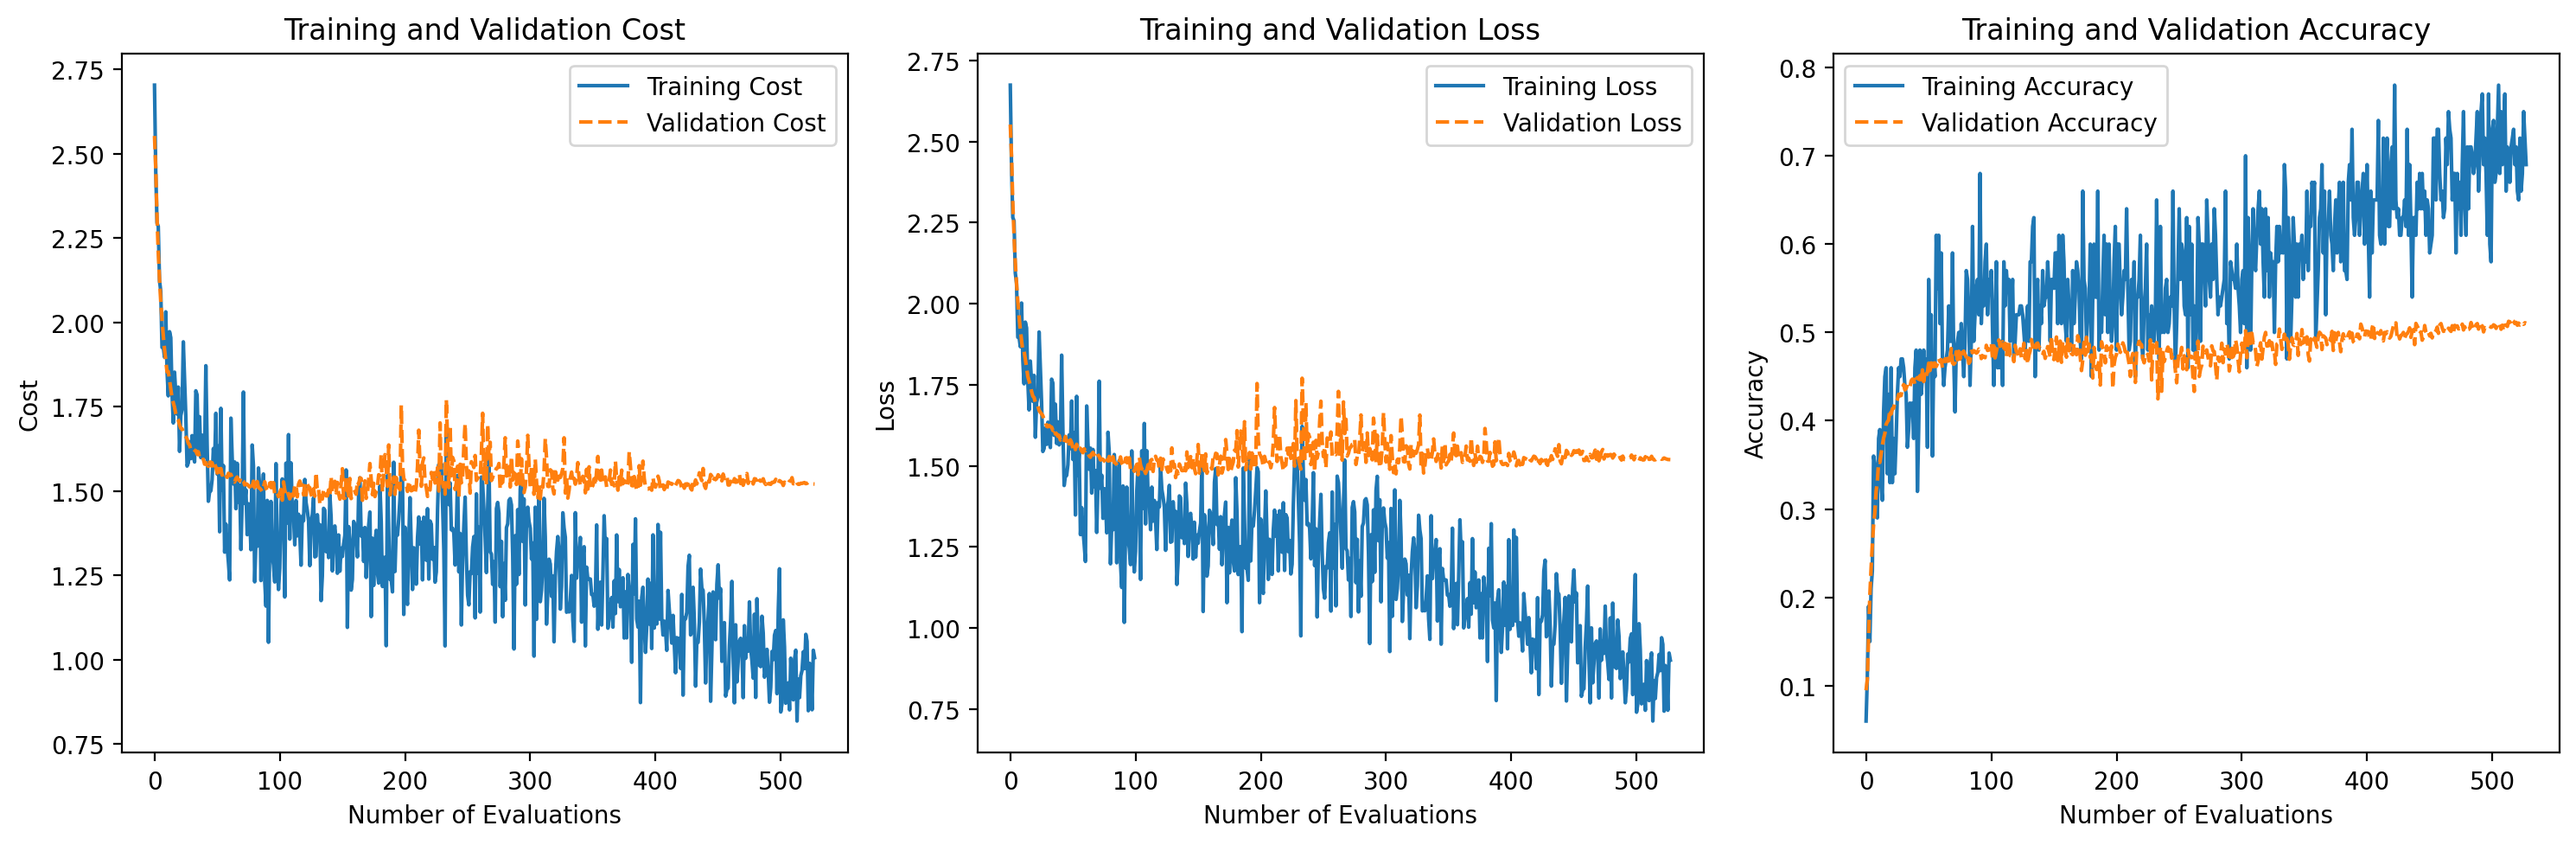

Lambda: 0.100000, Validation Accuracy: 0.5104


In [45]:
input_dim = 3072
hidden_dim = 50
output_dim = 10
epochs = 48 #100 # Set according to training strategy
batch_size = 100
#ns = 900

cycles = 1
num_minibatches = X_train.shape[1] // batch_size
total_iterations = epochs * num_minibatches
iterations_per_cycle = total_iterations / cycles
ns = int(iterations_per_cycle / 2)

lambdas = [1e-5, 0.000037, 0.1]  # The best 3 lambda determined from previous experiments

#params = initialize_parameters(input_dim, hidden_dim, output_dim)

results = []
for lambda_ in lambdas:
  print(f"\nStarting training with Lambda: {lambda_:.6f}")
  params = initialize_parameters(input_dim, hidden_dim, output_dim)
  params, train_costs, train_losses, train_accuracies, val_costs, val_losses, val_accuracies = train_with_cyclic_lr_val(
      X_train, Y_train, X_val, Y_val, test_X, test_Y, params, epochs, batch_size, ns, lambda_)
  final_accuracy = val_accuracies[-1]
  results.append((lambda_, final_accuracy))
  print(f"Lambda: {lambda_:.6f}, Validation Accuracy: {final_accuracy}")